<a href="https://colab.research.google.com/github/NucleiDatorum/Portfolio/blob/main/01_they_are_leaving_the_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЕТАНПРОМБАНК. АНАЛИЗ ОТТОКА КЛИЕНТОВ

**Описание:**<br>
региональный банк, расположенный в трёх российских городах - Ярославль, Рыбинск и Ростов Великий,<br>
столкнулся с проблемой оттока клиентов, масштабы которого угрожающе увеличиваются.<br>
Отделу маркетинга необходимо понять возможные причины такого поведения <br>
и разработать стратегию для удержания клиентов.<br>
Для анализа предоставлена следующая информация:<br>
идентификатор, пол и возраст клиента, город оформления банковского продукта,<br>
кредитный скоринг, баланс счёта, количество баллов собственности, количество продуктов, <br>
наличие кредитной карты, расчётный доход в месяц, активность за последние 30 дней, признак оттока.

**Задача:**<br>
выявить характерные признаки, указывающие на склонность к оттоку,<br>
разделить клиентов на несколько сегментов, приоритизировать сегменты по доле отточных,<br>
составить рекомендации для отдела маркетинга.

**Краткое содержание:**
- загрузим и исследуем данные;
- сформируем типичные портреты клиентов;
- выделим основные признаки, влияющие на отток;
- проверим гипотезы;
- проведём сегментацию клиентов;
- сформулируем выводы и предложим рекомендации для снижения оттока.

## Часть 1. Знакомство с данными

На этом шаге:
- загрузим все необходимые библиотеки;
- считаем предоставленные данные;
- оценим их объём и качество;
- изучим признаки и их тип (числовые или категориальные);
- проверим данные на наличие дубликатов;
- оценим количество пропусков.

In [1]:
# импорт библиотек для работы с данными
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# для статистического анализа
import scipy.stats as st

In [2]:
# скачивание файла .csv с гугл-диска
! gdown --id 1gWniMd8CfGUKSA1LWYBC0AfHQt5vgkwZ

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gWniMd8CfGUKSA1LWYBC0AfHQt5vgkwZ
To: /content/bank_scrooge.csv
100% 666k/666k [00:00<00:00, 68.1MB/s]


In [3]:
# чтение файла и сохранение его в переменную
df = pd.read_csv('/content/bank_scrooge.csv')

In [4]:
# первые строки датасета
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
# нормализуем названия столбцов и выведем общую информацию о таблице
df.columns = map(str.lower, df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Описание данных:
- `userid` — идентификатор пользователя;
- `score` — баллы кредитного скоринга;
- `city` — город
- `gender` — пол;
- `age` — возраст;
- `equity` — количество баллов собственности;
- `balance` — баланс на счёте;
- `products` — количество продуктов, которыми пользуется клиент;
- `credit_card` — есть ли кредитная карта;
- `last_activity` — активность клиента за последние 30 дней;
- `est_salary` — оценочный доход клиента;
- `churn` — признак оттока.

In [6]:
# количество дубликатов в колонке с id пользователя
df.userid.duplicated().sum()

73

In [7]:
# список повторяющихся id пользователя
dupl = df.query('userid.duplicated() == True')
dupl.userid.unique()

array([190253, 210662, 131419, 187635, 220816, 221156, 208081, 170312,
       185748, 211130, 217643, 226719, 197364, 155765, 126368, 218868,
       151662, 143592, 141265, 208815, 152479, 217619, 208738, 120258,
       188957, 228075, 172142, 163207, 210135, 219343, 164676, 214031,
       140377, 117943, 116540, 210792, 191520, 198635, 226550, 149365,
       216848, 148826, 206759, 210898, 227795, 210627, 221197, 123461,
       181526, 162053, 127440, 199312, 222480, 183510, 200863, 150667,
       202983, 155872, 187459, 217826, 141945, 129785, 160075, 185829,
       221809, 171751, 195884, 163657, 124450, 168998, 140934, 217412,
       175730])

In [8]:
# строки с id 190253
df.query('userid == 190253')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
1583,190253,726.0,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0


In [9]:
# строки с id 175730
df.query('userid == 175730')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7753,175730,846.0,Ярославль,Ж,32.0,7,216764.74,4,1,1,77100.85,1
9970,175730,816.0,Рыбинск,М,36.0,4,477892.07,3,1,0,81100.60,0


<div style="border:solid orange 1px; padding: 20px">
От сотрудников банка нам известно, что идентификатор пользователя - это всегда уникальное значение. <br>Разные города для одного id можно объяснить перемещениями клиентов и оформлением банковского продукта в другом городе. <br>
Другими словами, клиент может приобрести разные продукты в разных городах, но все они будут оформлены на один уникальный номер id.<br>
Но в таблице также есть разное значение пола и возраста для одного id, разный кредитный скоринг, разный баланс и доход. Как будто это разные люди.<br>
Но так как это невозможно по правилам банка, будем считать данное наблюдение ошибкой ввода или вывода данных. Дубликаты удалим.

In [10]:
# копия датасета до удаления дубликатов
df_copy = df.copy()

# удалим дубликаты
df = df.drop_duplicates(subset=['userid'])

# проверим результат
df.userid.duplicated().sum()

0

In [11]:
# количество удалённых строк
len(df_copy) - len(df)

73

<div style="border:solid orange 1px; padding: 20px">
Проверим данные на наличие неявных дубликатов, которые могли образоваться в результате разного написания одних и тех же слов.

In [12]:
# список уникальных названий городов
df.city.unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [13]:
# список уникальных обозначений пола
df.gender.unique()

array(['Ж', 'М'], dtype=object)

<div style="border:solid orange 1px; padding: 20px">
Неявных дубликатов нет.

In [14]:
# количество пропусков по каждой колонке
df.isna().sum().sort_values(ascending=False)

,0
balance,2260
age,4
userid,0
score,0
city,0
gender,0
equity,0
products,0
credit_card,0
last_activity,0


In [15]:
# доля пропусков по каждой колонке
df.isna().mean().sort_values(ascending=False)

,0
balance,0.227662
age,0.000403
userid,0.000000
score,0.000000
city,0.000000
gender,0.000000
equity,0.000000
products,0.000000
credit_card,0.000000
last_activity,0.000000


### Вывод 1

Таблица содержит 10 тысяч наблюдений по 12 признакам.<br>
6 признаков являются числовыми: кредитный скоринг, возраст, баллы собственности, баланс, количество продуктов и доход.<br>
3 признака являются бинарными или dummy-переменными, принимающими значения 0 и 1: кредитная карта, активность, признак оттока. В бинарный формат можно также перевести пол клиента и город.<br>
1 категориальный признак - id пользователя.<br>
В данных обнаружены дубликаты по id клиента - 73 строки. Удалены.<br>
В столбцах с возрастом и балансом есть пропуски.<br>
Из-за пропусков тип данных в столбце с возрастом - float, вместо int.

## Часть 2. Предобработка данных

На этом шаге:
- обработаем пропуски;
- исправим тип данных в столбце с возрастом;
- переведем пол и город в бинарный формат для построения матрицы корреляций.

4 пропуска с возрастом удалим, так как количество незначительное, а попытка заполнить чем-либо исказит результаты.

In [16]:
# копия датасета до удаления пропусков
df_copy2 = df.copy()

# удаление пропусков в столбце 'age'
df = df.dropna(subset=['age'])

# количество пропусков в столбце с возрастом
df['age'].isna().sum()

0

In [17]:
# количество удалённых строк
len(df_copy2) - len(df)

4

In [18]:
# исправление типа данных на целочисленный
df['age'] = df['age'].astype('int')

In [19]:
# процент пропусков в столбце 'balance'
df.balance.isna().mean()

0.22775370351708152

<div style="border:solid orange 1px; padding: 20px">
В столбце с балансом 23% пропусков.<br>
Удалить такое количество без ущерба для данных мы не можем.<br>
Заполнять средним или медианой также нецелесообразно, так как это исказит результаты.<br>
Посмотрим, есть ли в данных наблюдения с нулевым балансом:

In [20]:
# минимальный баланс
df.balance.min()

0.0

<div style="border:solid orange 1px; padding: 20px">
Да, в таблице встречается нулевой баланс.<br>
Сравним статистику клиентов с нулевым балансом со статистикой клиентов с пропусками.

In [21]:
# статистика по клиентам с нулевым балансом
df.query('balance == 0').describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2.00000,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.000000,2.000000,2.0
mean,164143.50000,771.500000,19.000000,1.000000,0.0,2.0,1.0,0.500000,44212.420000,0.0
std,22185.47526,58.689863,1.414214,1.414214,0.0,0.0,0.0,0.707107,28759.319725,0.0
min,148456.00000,730.000000,18.000000,0.000000,0.0,2.0,1.0,0.000000,23876.510000,0.0
25%,156299.75000,750.750000,18.500000,0.500000,0.0,2.0,1.0,0.250000,34044.465000,0.0
50%,164143.50000,771.500000,19.000000,1.000000,0.0,2.0,1.0,0.500000,44212.420000,0.0
75%,171987.25000,792.250000,19.500000,1.500000,0.0,2.0,1.0,0.750000,54380.375000,0.0
max,179831.00000,813.000000,20.000000,2.000000,0.0,2.0,1.0,1.000000,64548.330000,0.0


In [22]:
# статистика по клиентам с пропусками в балансе
df.query('balance.isna()').describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2260.000000,2260.000000,2260.000000,2260.000000,0.0,2260.000000,2260.000000,2260.000000,2.260000e+03,2260.000000
mean,171975.568584,865.334956,42.125664,0.051770,NaN,1.161504,0.815487,0.549115,2.267006e+05,0.005752
std,33277.188448,89.669447,11.953138,0.227525,NaN,0.401442,0.387988,0.497692,1.999817e+05,0.075642
min,114182.000000,642.000000,18.000000,0.000000,NaN,0.000000,0.000000,0.000000,2.027403e+04,0.000000
25%,143067.000000,871.000000,33.000000,0.000000,NaN,1.000000,1.000000,0.000000,1.204570e+05,0.000000
50%,172498.500000,903.000000,40.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.747554e+05,0.000000
75%,201354.250000,922.000000,49.000000,0.000000,NaN,1.000000,1.000000,1.000000,2.404518e+05,0.000000
max,229145.000000,990.000000,86.000000,3.000000,NaN,3.000000,1.000000,1.000000,1.333687e+06,1.000000


<div style="border:solid orange 1px; padding: 20px">
Как оказалось, нулевой баланс встречается только в двух случаях, что на уровне статистической погрешности.<br>
Таким образом, мы можем выделить клиентов с пропусками по балансу в отдельную категорию,
заменив пропуски нулями.<br>
Другими словами, 0 на балансе теперь будет означать "нет данных".

In [23]:
# замена пропусков на 0
df.loc[df.balance.isna() == True, 'balance'] = 0

# количество пропусков в столбце с балансом
df.balance.isna().sum()

0

<div style="border:solid orange 1px; padding: 20px">
Перед тем, как закодировать категориальные переменные пол и город в индикаторные 0/1, сохраним исходный датасет в отдельной переменной для удобства построения визуализаций.

In [24]:
# копия датасета для построения визуализаций
banks = df.copy()

In [25]:
# преобразуем пол в двоичный формат: 1 - мужчина, 0 - женщина
gender = {'gender': {'М':1, 'Ж':0}}
df = df.replace(gender)
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,0,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,0,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,0,30,0,0.00,1,1,1,107683.34,0
3,225363,866.0,Ярославль,0,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,1,34,5,174.00,1,1,0,67353.16,1


In [26]:
# закодируем город в бинарный формат
df = pd.get_dummies(df, prefix = '', prefix_sep = '', dtype=int, drop_first=False)
df.head()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
0,183012,850.0,0,25,1,59214.82,2,0,1,75719.14,1,0,1,0
1,146556,861.0,0,37,5,850594.33,3,1,0,86621.77,0,0,1,0
2,120722,892.0,0,30,0,0.00,1,1,1,107683.34,0,0,1,0
3,225363,866.0,0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,157978,730.0,1,34,5,174.00,1,1,0,67353.16,1,0,0,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9923 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9923 non-null   int64  
 1   score          9923 non-null   float64
 2   gender         9923 non-null   int64  
 3   age            9923 non-null   int64  
 4   equity         9923 non-null   int64  
 5   balance        9923 non-null   float64
 6   products       9923 non-null   int64  
 7   credit_card    9923 non-null   int64  
 8   last_activity  9923 non-null   int64  
 9   est_salary     9923 non-null   float64
 10  churn          9923 non-null   int64  
 11  Ростов         9923 non-null   int64  
 12  Рыбинск        9923 non-null   int64  
 13  Ярославль      9923 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 1.1 MB


### Вывод 2

Удалили 73 строки с дубликатами по id пользователя и 4 строки с пропусками в столбце с возрастом.<br>
Пропуски в столбце с балансом заполнили нулями.<br>
Обозначение пола закодировали в бинарный формат: 1 - мужчина, 0 - женщина.<br>
Города также перевели в бинарный формат, <br>
заменив общий столбец city на три столбца отдельно для каждого города, где 0 - нет, 1 - да.<br>
Исходный датасет до кодировки сохранили в переменную banks.<br>
Тип данных с возрастом исправили на целочисленный.

## Часть 3. Исследовательский анализ данных

На этом шаге:
- изучим общую статистику;
- посмотрим на распределения признаков;
- составим портреты клиентов;
- построим матрицу корреляций.

### Общая статистика

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,9923.0,171731.481205,3.369437e+04,94561.0,142720.000,172635.00,201157.500,2.291450e+05
score,9923.0,848.732339,6.540011e+01,642.0,802.000,853.00,900.000,1.000000e+03
gender,9923.0,0.500857,5.000245e-01,0.0,0.000,1.00,1.000,1.000000e+00
age,9923.0,42.729215,1.217701e+01,18.0,33.000,40.00,51.000,8.600000e+01
equity,9923.0,2.634284,1.979328e+00,0.0,0.000,3.00,4.000,9.000000e+00
balance,9923.0,639611.573997,1.777947e+06,0.0,63675.675,376590.60,805244.385,1.191136e+08
products,9923.0,1.871511,7.931103e-01,0.0,1.000,2.00,2.000,5.000000e+00
credit_card,9923.0,0.680036,4.664857e-01,0.0,0.000,1.00,1.000,1.000000e+00
last_activity,9923.0,0.523330,4.994806e-01,0.0,0.000,1.00,1.000,1.000000e+00
est_salary,9923.0,147886.494764,1.393639e+05,2546.3,75252.125,119719.33,174673.285,1.395064e+06


В выборке одинаковое количество мужчин и женщин.<br>
Средний возраст клиентов 42-43 года. Минимальный возраст - 18 лет, максимальный - 86.<br>
Максимальный баланс на счёте 119 миллионов выглядит как выброс.<br>
Так же обращает на себя внимание минимальный расчётный доход в 2,5 тысячи.<br>
Минимальное количество продуктов 0 может быть ошибкой, так как известно, что человек становится клиентом банка только при условии оформления какого-либо банковского продукта. <br>
68% клиентов имеют кредитную карту.<br>
Чуть больше половины клиентов проявляли какую-либо активность за последние 30 дней.<br>
Почти 60% всех клиентов приходится на Ярославль.<br>
Ушедших в отток клиентов - 18% от общего числа.

In [29]:
# все наблюдения, в которых количество продуктов равно 0
df.query('products == 0')

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
8957,147837,962.0,0,79,3,0.0,0,0,0,25063.96,1,0,1,0


Учитывая довольно преклонный возраст клиентки и отсутствие средств на счёте можно предположить, что признак оттока связан с уходом из жизни. Но мы не знаем этого наверняка, поэтому удалим это единственное наблюдение с нулевым количеством продуктов.

In [30]:
# копия датасета до удаления
df_copy3 = df.copy()

# удаление строки с нулевым количеством продуктов по индексу
df = df.drop (index = 8957)

# количество наблюдений, в которых products равно 0
len(df.query('products == 0'))

0

In [31]:
# количество удалённых строк
len(df_copy3) - len(df)

1

In [32]:
# удаление строки с нулевым количеством продуктов из таблицы "banks"
banks = banks.drop (index = 8957)

### Выбросы

Выброс - это наблюдение, которое лежит аномально далеко от других значений в наборе данных.<br>
Это может быть ошибка ввода/вывода данных,<br>
но может быть и просто редкий признак.

#### Низкие доходы

In [33]:
# срез по доходу менее 10 тысяч
df.query('est_salary < 10000')

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
505,205035,725.0,0,77,3,73.00,2,0,1,8729.84,0,0,1,0
1700,155567,747.0,1,25,0,5750.92,1,1,0,7054.82,0,1,0,0
1753,161271,836.0,0,19,4,7703.05,4,1,1,5043.14,0,0,0,1
1883,151268,852.0,0,63,5,373070.37,1,1,1,8587.79,0,1,0,0
1988,160979,788.0,1,24,4,118438.82,2,1,0,8401.97,0,0,1,0
2174,143340,830.0,0,72,2,294375.63,3,1,1,8032.18,0,0,0,1
2186,201407,938.0,0,69,1,325483.52,3,0,1,3487.33,0,0,1,0
2663,140105,821.0,0,75,7,631805.72,1,1,0,8894.57,0,1,0,0
3606,187819,839.0,0,56,5,1027438.02,2,0,0,7571.80,0,0,1,0
3689,219561,817.0,1,25,3,121065.39,4,1,1,7522.14,0,1,0,0


<div style="border:solid orange 1px; padding: 20px">
Довольно интересный получился срез:<br>
среди клиентов либо молодые люди, либо пожилые и все клиенты не отточные.<br><br>
Особый интерес вызывает клиент с id 187819 с балансом на счёте более миллиона и доходом 7,5 тысяч -<br>
ей 56 лет, 5 баллов собственности и не пользуется кредитной картой.<br><br>
В срезе также есть молодые люди с баллами собственности 3-5 и балансом 100 и более тысяч при небольшом доходе.<br>
А с другой стороны - женщина 77 лет, 3 балла собственности и баланс 73 рубля, доход 8.7 тысяч<br>
(правда, была активность за последний месяц, возможно, снятие наличных или перевод).<br><br>
Клиент с самым низким по всей выборке доходом - <br>
это девушка 26 лет из Ярославля, имеет 1 балл собственности, кредитную карту и 77 тысяч на счёте.<br><br>
Таким образом, можно предположить, что большинство клиентов с низкими доходами - <br>
это молодые люди (возможно, студенты) и пенсионеры, у которых есть родственники или опекуны, оказывающие им финансовую помощь.<br>
Другими словами, низкий уровень дохода - это не ошибка, а определённая категория клиентов.

#### Высокие доходы

In [34]:
# срез с доходами от 1 миллиона рублей
df.query('est_salary > 1000000')

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
125,227092,1000.0,1,32,5,19757180.85,2,1,1,1024626.50,0,0,0,1
149,218801,958.0,1,34,0,0.00,1,1,0,1292825.74,0,0,0,1
178,226887,890.0,1,49,4,3956103.10,2,1,0,1120528.70,0,0,0,1
250,210357,766.0,1,27,0,0.00,1,1,0,1015754.12,0,0,0,1
296,204143,925.0,1,25,0,0.00,2,1,0,1001009.40,0,0,0,1
302,164876,942.0,1,40,0,0.00,1,1,0,1256537.74,0,0,0,1
663,180853,949.0,1,45,0,0.00,1,1,0,1142166.48,0,0,0,1
996,127574,749.0,1,35,0,0.00,1,1,0,1071600.78,0,0,0,1
1027,119793,1000.0,1,50,5,12909691.02,1,1,0,1253653.40,0,0,0,1
1273,136567,961.0,1,31,0,0.00,1,1,0,1015386.14,1,0,0,1


<div style="border:solid orange 1px; padding: 20px">
В клуб зарплатных миллионеров входят исключительно жители Ярославля,<br>
при этом у значительной части из них 0 баллов собственности и 0 на балансе счёта.<br>
Ноль на счёте может быть ошибкой ввода/вывода данных или признаком того, что у клиента есть счета в других банках,<br>
а собственность может быть записана на детей и супругов.<br>
Т.е., высокие зарплаты - это также отдельная категория.

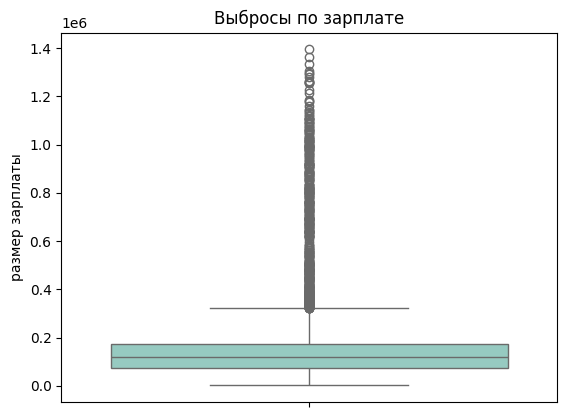

In [35]:
# визуализация выбросов по зарплате
sns.boxplot(data=df,
            y='est_salary',
            palette='Set3')
plt.ylabel('размер зарплаты')
plt.title('Выбросы по зарплате');

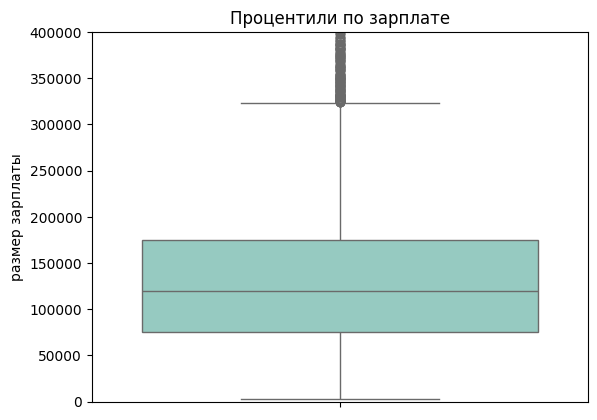

In [36]:
# визуализация по зарплате с ограничением по оси Y
sns.boxplot(data=df,
            y='est_salary',
            palette='Set3')
plt.ylim(0, 400000)
plt.ylabel('размер зарплаты')
plt.title('Процентили по зарплате');

In [37]:
# процентили по зарплате
df.est_salary.quantile([.25, .50, .75, .95])

,est_salary
0.25,75254.0450
0.50,119735.4300
0.75,174679.6375
0.95,316862.9855


<div style="border:solid orange 1px; padding: 20px">
Большинство наблюдений лежат в диапазоне от 75 до 175 тысяч рублей.<br>
25% клиентов имеют доход от 2.5 до 75 тысяч,<br>
20% имеют доход от 175 до 317 тысяч<br>
и у 5% доходит до 1.4 миллиона.

In [38]:
# минимальный доход
df.est_salary.min()

2546.3

In [39]:
# максимальный доход
df.est_salary.max()

1395064.45

In [40]:
# разделим выборку на две части:
# на оставшихся(0) и ушедших в отток(1)
churn_0 = df.query('churn == 0')
churn_1 = df.query('churn == 1')

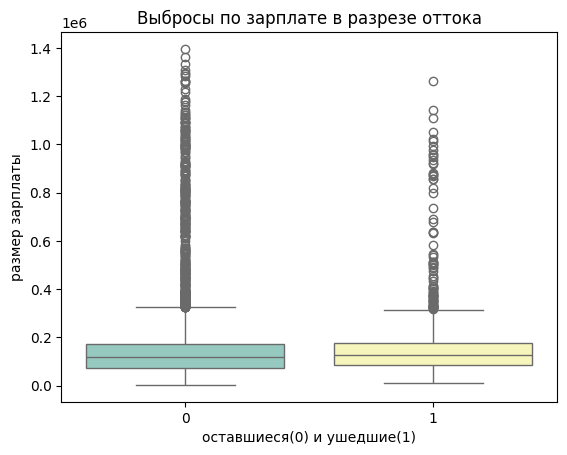

In [41]:
# визуализация выбросов по зарплате в разрезе оттока
sns.boxplot(data=df,
            x='churn',
            y='est_salary',
            palette='Set3')
plt.xlabel('оставшиеся(0) и ушедшие(1)')
plt.ylabel('размер зарплаты')
plt.title('Выбросы по зарплате в разрезе оттока');

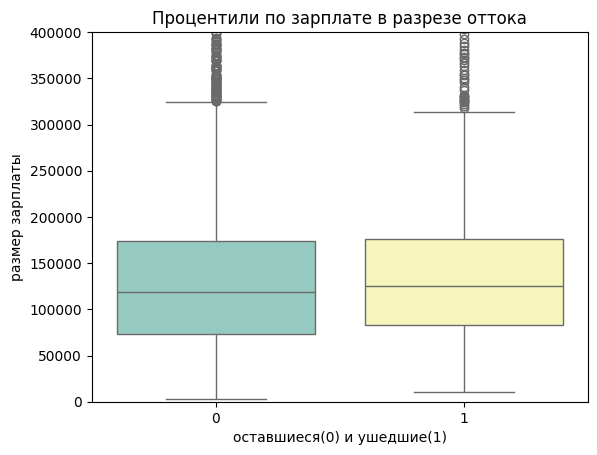

In [42]:
# визуализация по зарплате в разрезе оттока
# с ограничением по оси Y
sns.boxplot(data=df,
            x='churn',
            y='est_salary',
            palette='Set3')
plt.ylim(0, 400000)
plt.xlabel('оставшиеся(0) и ушедшие(1)')
plt.ylabel('размер зарплаты')
plt.title('Процентили по зарплате в разрезе оттока');

In [43]:
# процентили по зарплате оставшихся клиентов
salary_percentile_0 = (churn_0['est_salary']
                       .quantile([.25, .50, .75, .95])
                       .reset_index()
                       .rename(columns={'index': 'процентиль',
                                        'est_salary': 'зарплата_оставшихся'}))

# процентили по зарплате ушедших клиентов
salary_percentile_1 = (churn_1['est_salary']
                       .quantile([.25, .50, .75, .95])
                       .reset_index()
                       .rename(columns={'index': 'процентиль',
                                        'est_salary': 'зарплата_ушедших'}))

# объединение в одну таблицу
salary_percentile = pd.merge(salary_percentile_0,
                             salary_percentile_1,
                             on='процентиль')
salary_percentile

,процентиль,зарплата_оставшихся,зарплата_ушедших
0,0.25,73487.0700,83285.6600
1,0.50,118248.5150,125408.8800
2,0.75,174106.0425,176017.8375
3,0.95,320951.5495,304056.7930


<div style="border:solid orange 1px; padding: 20px">
Статистика по зарплате в группе ушедших хоть и не сильно, но отличается от оставшихся - <br>
немного выше медиана, первый и третий квартили, а 95 процентиль, напротив, ниже <br>
и максимальный выброс имеет меньшее значение.<br>
Максимальная отточность наблюдается в группе клиентов с зарплатой в пределах 125 тысяч.<br>
Посмотрим распределение зарплат на гистограмме, но сначала ограничим выборку отсечением правого хвоста,<br>
чтобы выбросы не мешали визуальной оценке.

In [44]:
# срезы по зарплате до 350 тыс. и признаку отточности
df_2 = df.query('est_salary < 350000')
churn_0_2 = df_2.query('churn == 0')
churn_1_2 = df_2.query('churn == 1')

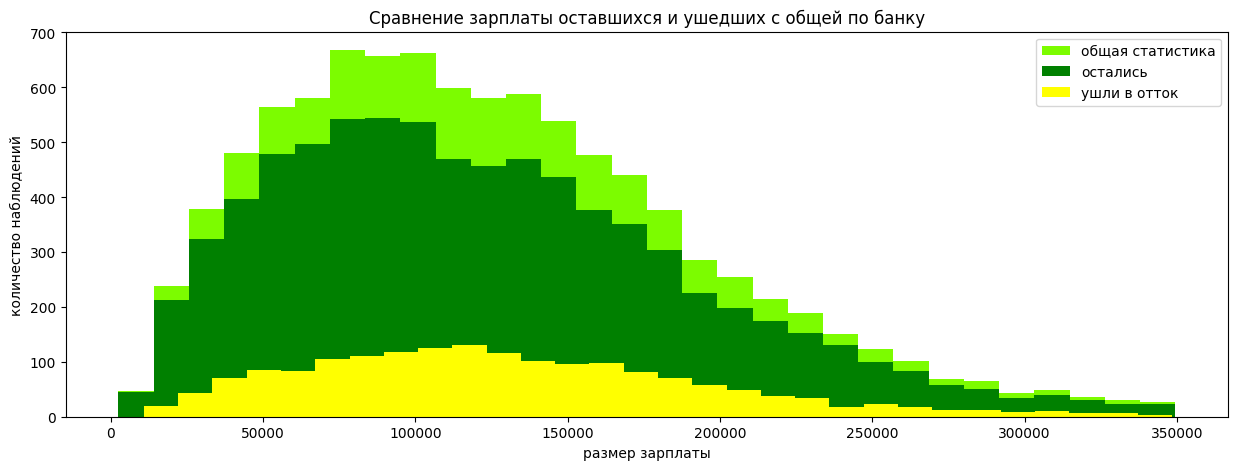

In [45]:
# визуализация распределения зарплат по группам отточных и оставшихся
# в сравнении с общей статистикой
n_bins = 30
plt.subplots(figsize = (15,5))

plt.hist(df_2.est_salary,
         n_bins,
         color='LawnGreen',
         label='общая статистика')

plt.hist(churn_0_2.est_salary,
         n_bins,
         color='Green',
         label='остались')

plt.hist(churn_1_2.est_salary,
         n_bins,
         color='Yellow',
         label='ушли в отток')

plt.xlabel('размер зарплаты')
plt.ylabel('количество наблюдений')
plt.title('Сравнение зарплаты оставшихся и ушедших с общей по банку')
plt.legend();

<div style="border:solid orange 1px; padding: 20px">
Пик распределения для отточных клиентов относительно оставшихся смещён вправо, в сторону бОльших зарплат.

#### Максимальный баланс

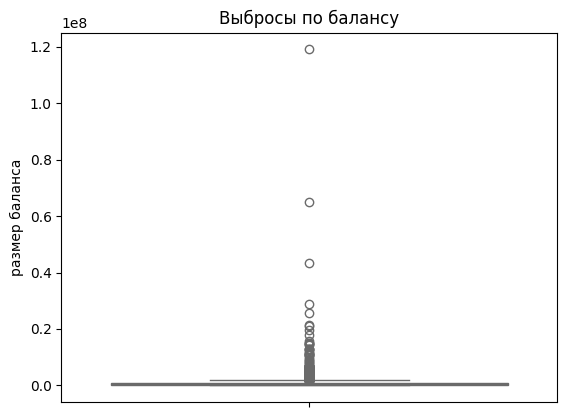

In [46]:
# визуализация выбросов по балансу
sns.boxplot(data=df,
            y='balance',
            palette='Set3')
plt.ylabel('размер баланса')
plt.title('Выбросы по балансу');

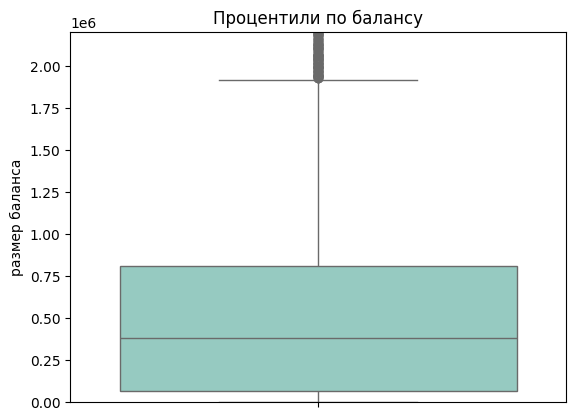

In [47]:
# визуализация по балансу с ограничением по оси Y
sns.boxplot(data=df,
            y='balance',
            palette='Set3')
plt.ylim(0, 2200000)
plt.ylabel('размер баланса')
plt.title('Процентили по балансу');

In [48]:
# процентили по балансу
df.balance.quantile([.25, .50, .75, .95])

,balance
0.25,6.374143e+04
0.50,3.767156e+05
0.75,8.053314e+05
0.95,1.847426e+06


<div style="border:solid orange 1px; padding: 20px">
Ящик с усами заметно смещён вниз в сторону нуля, что отражает большое количество счетов с нулевым балансом.<br>
Четверть клиентов имеют на балансе не более 64 тысяч рублей.<br>
У половины клиентов баланс не превышает 377 тысяч.<br>
У 5% на счёте хранится свыше 1.8 миллиона.<br><br>
Другими словами, типичным балансом для данной выборки являются суммы от 64 до 805 тысяч,<br>
25% имеют низкий баланс от 0 до 64 тысяч, 20% высокий - от 805 тыс. до 1.8 млн.<br>
и 5% выбросов от 1.8 до 119 млн.<br>

In [49]:
# максимальный баланс
df.balance.max()

119113552.01

In [50]:
# срез с балансом от 100 миллионов
df.query('balance > 100000000')

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
7597,156149,900.0,1,62,5,1.191136e+08,2,1,1,138041.31,0,0,0,1


<div style="border:solid orange 1px; padding: 20px">
Владелец счёта с балансом 119 миллионов - мужчина предпенсионного возраста из Ярославля, 5 баллов собственности, доход 138<br> тысяч, был активен последние 30 дней, пользуется двумя продуктами, есть кредитная карта.<br>
Данное наблюдение хоть и очень редкое, но теоретически, вполне реалистичное.<br>
У нас нет оснований утверждать, что это ошибка.

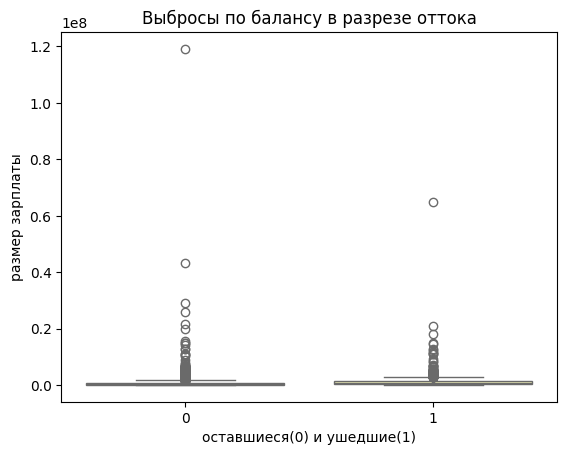

In [51]:
# визуализация выбросов по балансу в разрезе оттока
sns.boxplot(data=df,
            x='churn',
            y='balance',
            palette='Set3')
plt.xlabel('оставшиеся(0) и ушедшие(1)')
plt.ylabel('размер зарплаты')
plt.title('Выбросы по балансу в разрезе оттока');

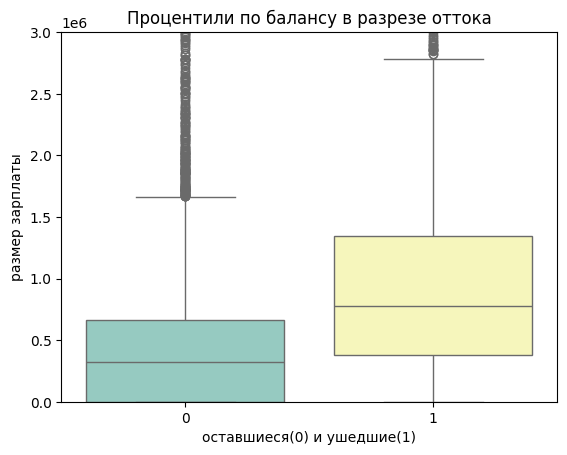

In [52]:
# визуализация по балансу в разрезе оттока
# с ограничением по оси Y
sns.boxplot(data=df,
            x='churn',
            y='balance',
            palette='Set3')
plt.ylim(0, 3000000)
plt.xlabel('оставшиеся(0) и ушедшие(1)')
plt.ylabel('размер зарплаты')
plt.title('Процентили по балансу в разрезе оттока');

In [53]:
# процентили по балансу оставшихся клиентов
balance_percentile_0 = (churn_0['balance']
                        .quantile([.25, .50, .75, .95])
                        .reset_index()
                        .rename(columns={'index': 'процентиль',
                                        'balance': 'баланс_оставшихся'}))

# процентили по балансу ушедших клиентов
balance_percentile_1 = (churn_1['balance']
                        .quantile([.25, .50, .75, .95])
                        .reset_index()
                        .rename(columns={'index': 'процентиль',
                                        'balance': 'баланс_ушедших'}))

# объединение в одну таблицу
balance_percentile = pd.merge(balance_percentile_0,
                              balance_percentile_1,
                              on='процентиль')
balance_percentile

,процентиль,баланс_оставшихся,баланс_ушедших
0,0.25,0.000000e+00,3.820381e+05
1,0.50,3.216929e+05,7.753995e+05
2,0.75,6.656698e+05,1.347250e+06
3,0.95,1.448354e+06,2.980907e+06


<div style="border:solid orange 1px; padding: 20px">
В отличие от зарплаты, статистика по балансу между группой оставшихся и ушедших заметно отличается - <br>
все процентили для ушедших клиентов практически в два раза больше, <br>
а максимальный выброс значительно меньше.<br>
Посмотрим распределение баланса на гистограмме,<br>
Но сначала ограничим датасет по балансу от 2.5 тысяч до 1.5 миллиона,<br>
поскольку большое количество нулей (более 2 тысяч наблюдений) и выбросы помешают визуальной оценке.

In [54]:
f'Количество наблюдений с нулевым балансом: {len(df.query("balance == 0"))}'

'Количество наблюдений с нулевым балансом: 2261'

In [55]:
# срезы по балансу от 2.5 тыс. до 1.5 млн.
# и признаку отточности
df_3 = df.query('balance > 2500 & balance < 1500000')
churn_0_3 = df_3.query('churn == 0')
churn_1_3 = df_3.query('churn == 1')

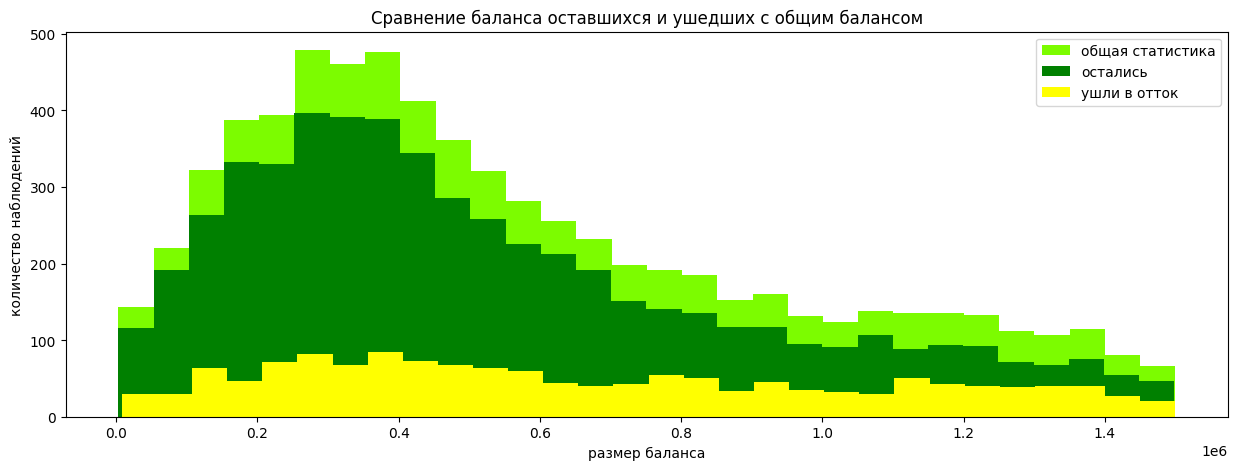

In [56]:
# визуализация распределения баланса по группам отточных и оставшихся
# в сравнении с общей статистикой
n_bins = 30
plt.subplots(figsize = (15,5))

plt.hist(df_3.balance,
         n_bins,
         color='LawnGreen',
         label='общая статистика')

plt.hist(churn_0_3.balance,
         n_bins,
         color='Green',
         label='остались')

plt.hist(churn_1_3.balance,
         n_bins,
         color='Yellow',
         label='ушли в отток')

plt.xlabel('размер баланса')
plt.ylabel('количество наблюдений')
plt.title('Сравнение баланса оставшихся и ушедших с общим балансом')
plt.legend();

<div style="border:solid orange 1px; padding: 20px">
Баланс отточных клиентов распределён более равномерно в сравнении с оставшимися, нет явно выраженных пиков.<br>
Также следует отметить, что среди отточных нет клиентов с нулевым балансом.

In [57]:
x = len(df.query('balance > est_salary')) / len(df) * 100
f'Процент клиентов, у которых баланс больше дохода: {round(x)}'

'Процент клиентов, у которых баланс больше дохода: 73'

<div style="border:solid orange 1px; padding: 20px">
Подавляющее большинство клиентов склонны к накоплению и ,возможно, активному приумножению своих доходов.

### Распределение признаков

Распределение признака - это закономерность встречаемости разных его значений.<br>
Когда крайние значения признака встречаются достаточно редко,<br>
а близкие к средней величине - достаточно часто,<br>
такое распределение считается нормальным.

#### Функции

##### stat_group

In [58]:
def stat_group(sign, x_0, группа_0, x_1, группа_1):
    """Функция для вывода статистики для определённого признака по двум группам клиентов.

    На вход функция принимает название признака,
    столбец с признаком из первого и столбец с признаком из второго среза данных (x_0 и x_1),
    которые образовались при делении датасета на какие-либо две группы.
    А также названия полученных групп, например:
    мужчины и женщины, оставшиеся и ушедшие и т.п.
    """
    pass
    d_0 = x_0.describe().reset_index()
    d_0.columns = [sign, группа_0]
    d_1 = x_1.describe().reset_index()
    d_1.columns = [sign, группа_1]
    d = pd.merge(d_0, d_1, left_on=sign, right_on=sign)
    display(d)

##### countplot_group

In [59]:
def countplot_group(x_0, группа_0, x_1, группа_1, X_name, Y_name, title):
    """Функция для построения графиков частоты встречаемости признака по двум группам клиентов.

    На вход функция принимает признак из первого и признак из второго среза данных (x_0 и x_1),
    которые образовались при делении датасета на какие-либо две группы.
    А также названия полученных групп, например:
    мужчины и женщины, оставшиеся и ушедшие и т.п.,
    названия осей X и Y, название графика.
    """
    pass
    plt.subplots(figsize = (15,5))
    sns.countplot(x=x_0, color='Yellow', label=группа_0)
    sns.countplot(x=x_1, color='Green', label=группа_1, alpha=.66)
    sns.set_context(rc={'font.size':11})
    plt.xlabel(X_name)
    plt.ylabel(Y_name)
    plt.title(title)
    plt.legend();

#### Возраст клиентов

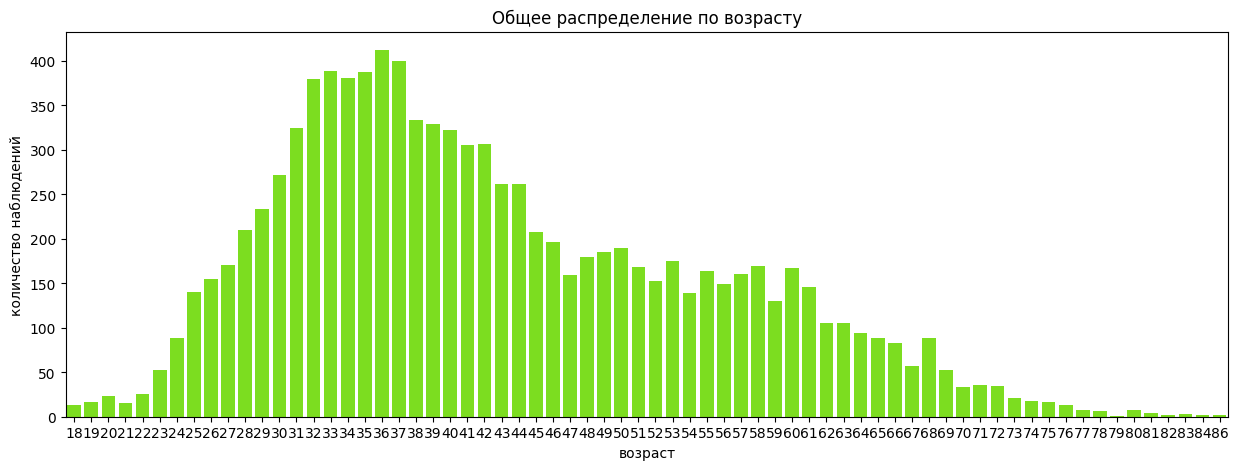

In [60]:
# визуализация общего распределения клиентов по возрасту
plt.subplots(figsize = (15,5))
sns.countplot(x=df.age, color='LawnGreen')
sns.set_context(rc={'font.size':10})
plt.xlabel('возраст')
plt.ylabel('количество наблюдений')
plt.title('Общее распределение по возрасту');

In [61]:
# общая статистика для возраста по группам
stat_group('возраст',
           churn_0.age, 'оставшиеся',
           churn_1.age, 'отток')

,возраст,оставшиеся,отток
0,count,8104.000000,1818.000000
1,mean,43.016288,41.429593
2,std,12.372982,11.144754
3,min,18.000000,18.000000
4,25%,34.000000,32.000000
5,50%,40.000000,39.000000
6,75%,51.000000,52.000000
7,max,86.000000,75.000000


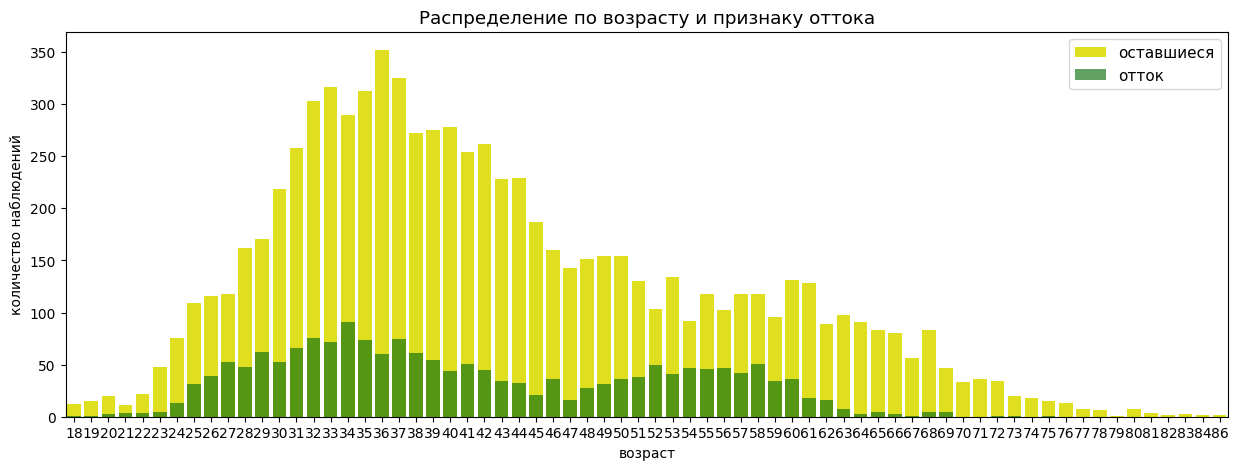

In [62]:
# график частоты встречаемости каждого возраста по группам
countplot_group(churn_0['age'], 'оставшиеся',
                churn_1['age'], 'отток',
                'возраст',
                'количество наблюдений',
                'Распределение по возрасту и признаку оттока')

<div style="border:solid orange 1px; padding: 20px">
Для группы оставшихся клиентов мы видим распределение по возрасту близкое к нормальному, но с заметной асимметрией вправо.<br>
А в группе отточных проявилось бимодальное распределение, разделившее выборку на условно "молодых" и "пожилых".<br>
Среди "молодых" из группы оттока пик приходится на 34 года, среди "пожилых" два пика - 52 и 58 лет.

In [63]:
# квантили по возрасту
df.age.quantile([.25, .50, .75, .95])

,age
0.25,33.0
0.50,40.0
0.75,51.0
0.95,65.0


#### Количество продуктов

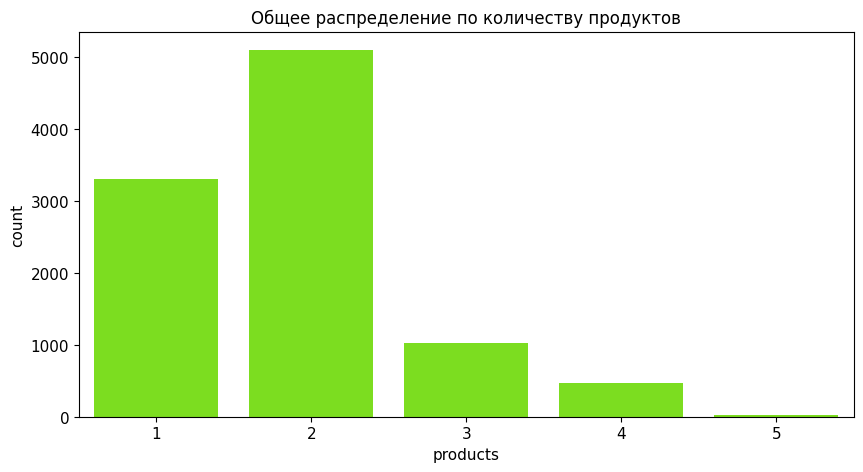

In [64]:
# визуализация общего распределения клиентов по количеству используемых продуктов
plt.subplots(figsize = (10,5))
sns.countplot(x=df.products, color='LawnGreen')
sns.set_context(rc={'font.size':10})
plt.title('Общее распределение по количеству продуктов');

In [65]:
# общая статистика по количеству продуктов и признаку оттока
stat_group('количество_продуктов',
           churn_0.products, 'оставшиеся',
           churn_1.products, 'отток')

,количество_продуктов,оставшиеся,отток
0,count,8104.000000,1818.000000
1,mean,1.758268,2.377338
2,std,0.713358,0.922162
3,min,1.000000,1.000000
4,25%,1.000000,2.000000
5,50%,2.000000,2.000000
6,75%,2.000000,3.000000
7,max,5.000000,5.000000


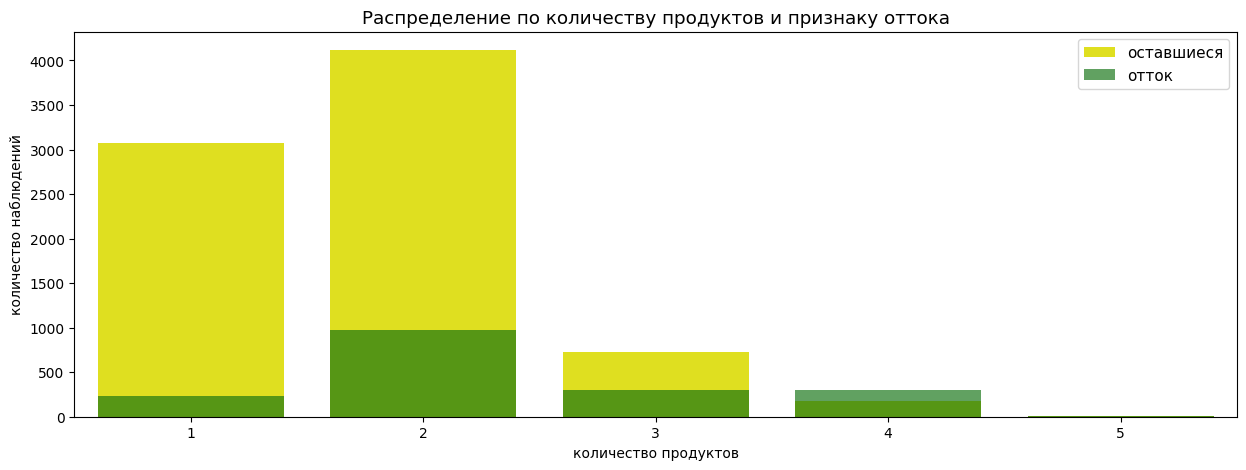

In [66]:
# распределение количества продуктов по признаку оттока
countplot_group(churn_0['products'], 'оставшиеся',
                churn_1['products'], 'отток',
                'количество продуктов',
                'количество наблюдений',
                'Распределение по количеству продуктов и признаку оттока')

<div style="border:solid orange 1px; padding: 20px">
Распределение среди оставшихся совпадает с общим распределением - большинство клиентов пользуются двумя продуктами.<br>
Для отточных клиентов распределение отличается тем, что группа с тремя продуктами больше группы с одним, а группа с четырьмя продуктами равна группе с тремя и это единственная группа, в которой количество отточных клиентов преобладает над оставшимися.

#### Баллы собственности

In [67]:
# общая статистика по баллам собственности и признаку оттока
stat_group('баллы собственности',
           churn_0.equity, 'оставшиеся',
           churn_1.equity, 'отток')

,баллы собственности,оставшиеся,отток
0,count,8104.000000,1818.000000
1,mean,2.380923,3.763476
2,std,1.970443,1.586316
3,min,0.000000,0.000000
4,25%,0.000000,3.000000
5,50%,3.000000,4.000000
6,75%,4.000000,5.000000
7,max,9.000000,9.000000


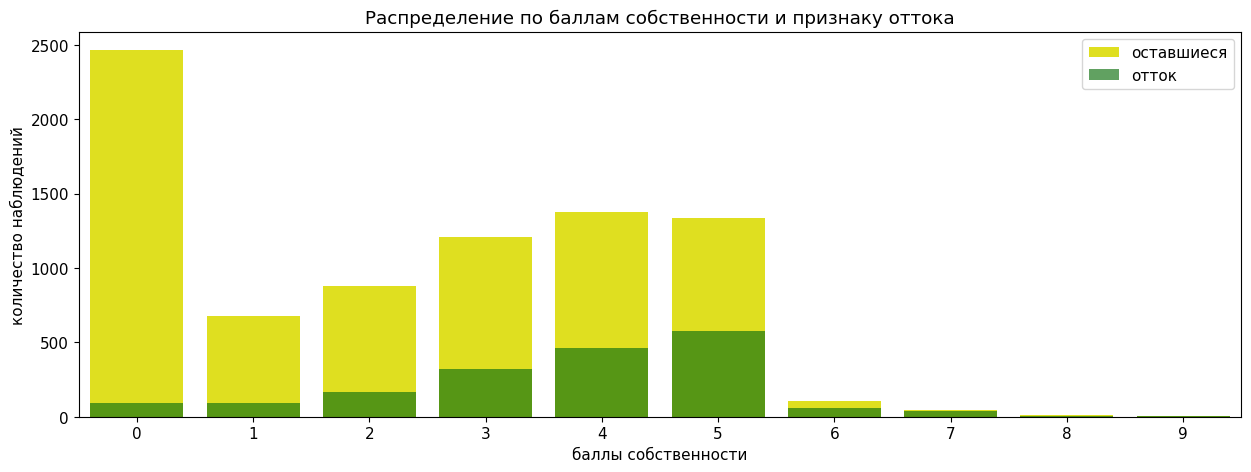

In [68]:
# распределение по баллам собственности и признаку оттока
countplot_group(churn_0['equity'], 'оставшиеся',
                churn_1['equity'], 'отток',
                'баллы собственности',
                'количество наблюдений',
                'Распределение по баллам собственности и признаку оттока')

<div style="border:solid orange 1px; padding: 20px">
Большинство ушедших клиентов имели 4-5 баллов собственности.<br>
Среди оставшихся больше тех, у кого 0 баллов.<br>

#### Кредитная карта

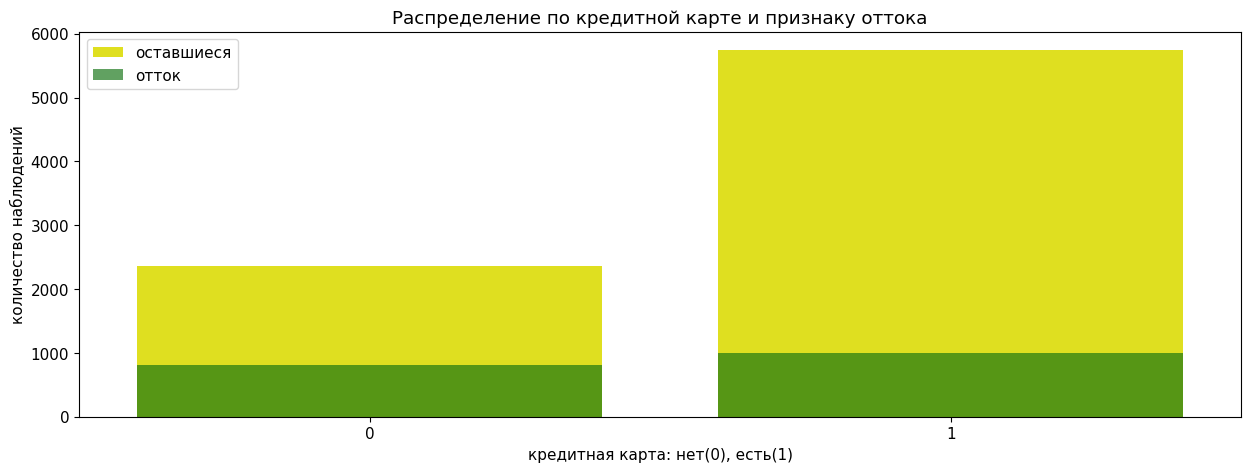

In [69]:
# распределение по наличию кредитной карты и признаку оттока
countplot_group(churn_0['credit_card'], 'оставшиеся',
                churn_1['credit_card'], 'отток',
                'кредитная карта: нет(0), есть(1)',
                'количество наблюдений',
                'Распределение по кредитной карте и признаку оттока')

<div style="border:solid orange 1px; padding: 20px">
Среди отточных клиентов держателей кредитной карты и тех, у кого её нет, примерно поровну.<br>
Среди оставшихся - без карты вполовину меньше.     

#### Активность за последние 30 дней

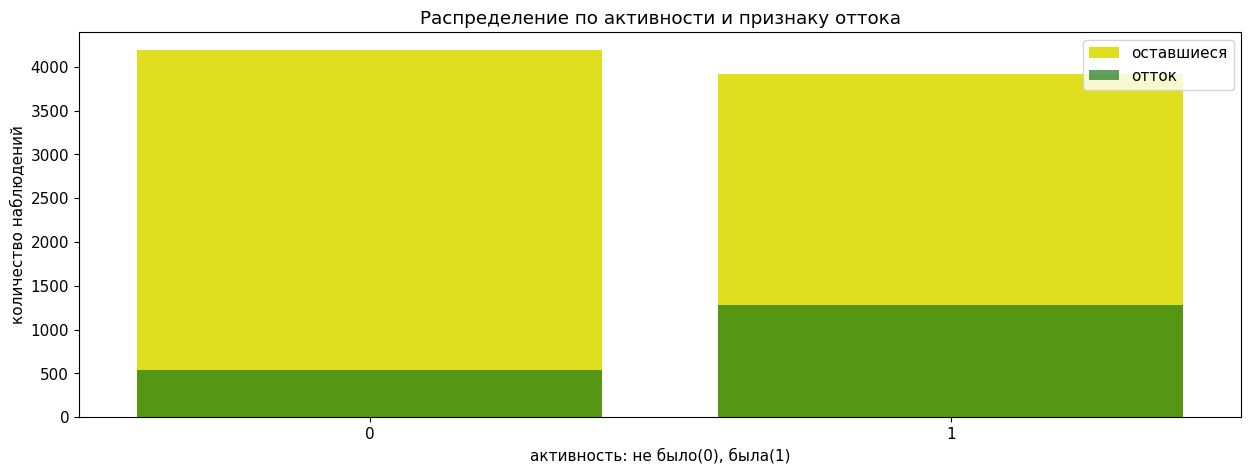

In [70]:
# распределение по активности и признаку оттока
countplot_group(churn_0['last_activity'], 'оставшиеся',
                churn_1['last_activity'], 'отток',
                'активность: не было(0), была(1)',
                'количество наблюдений',
                'Распределение по активности и признаку оттока')

<div style="border:solid orange 1px; padding: 20px">
Большинство отточных клиентов проявляли активность за последние 30 дней.       

#### Баланс и зарплата

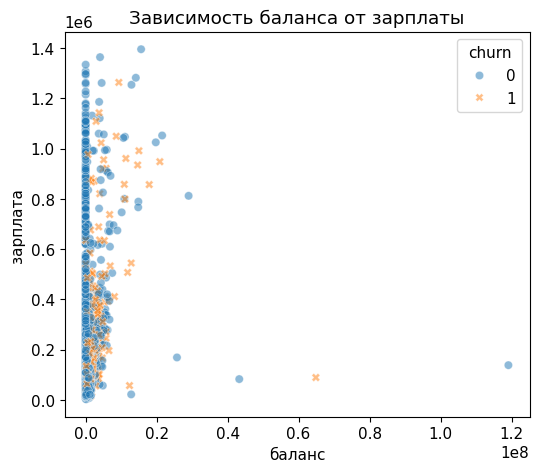

In [71]:
# корреляция между балансом и зарплатой
plt.subplots(figsize = (6,5))
sns.scatterplot(x='balance',
                y='est_salary',
                data=df,
                hue='churn',
                style='churn',
                alpha = 0.5)
plt.xlabel('баланс')
plt.ylabel('зарплата')
plt.title('Зависимость баланса от зарплаты');

<div style="border:solid orange 1px; padding: 20px">
Практически при любом уровне дохода баланс может быть нулевым.<br>
Особенно это характерно для оставшихся клиентов и в меньшей степени для отточных.<br>
Редко, но встречается большой баланс при сравнительно небольшой зарплате.<br>

#### Кредитный скоринг

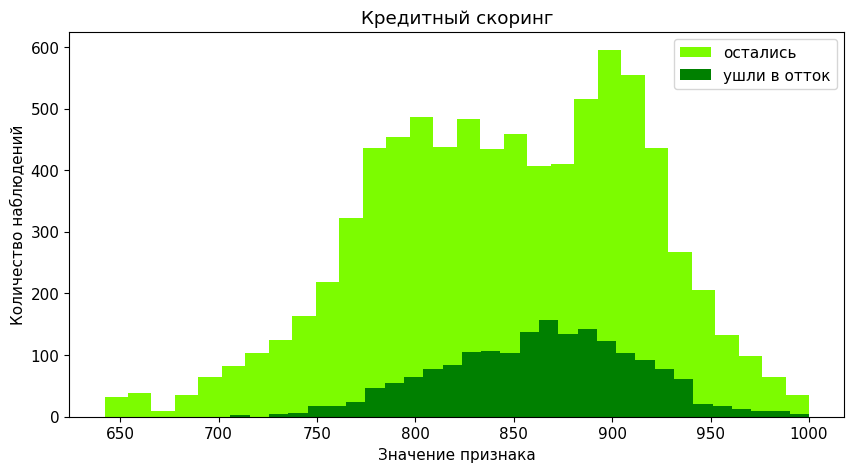

In [72]:
# распределение кредитного скоринга
n_bins = 30
plt.subplots(figsize = (10,5))

plt.hist(churn_0.score,
         n_bins,
         color = 'LawnGreen',
         label='остались')

plt.hist(churn_1.score,
         n_bins,
         color = 'Green',
         label='ушли в отток')

plt.xlabel('Значение признака')
plt.ylabel('Количество наблюдений')
plt.title('Кредитный скоринг')
plt.legend();

<div style="border:solid orange 1px; padding: 20px">
У большинства оставшихся средний кредитный скоринг выше, чем у отточных клиентов.  

#### Матрица корреляций

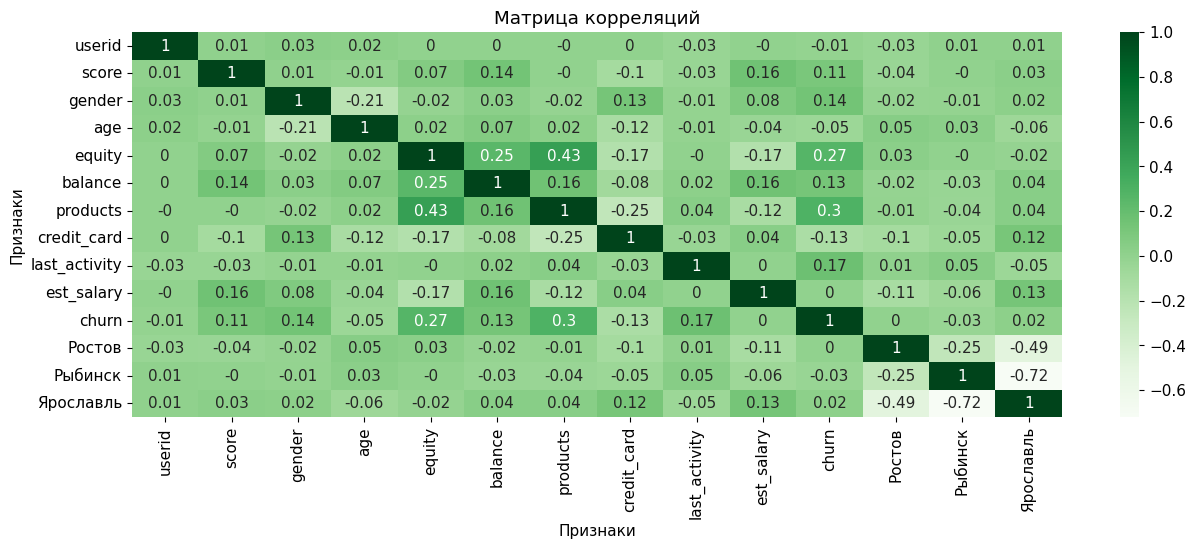

In [73]:
cm = df.corr().round(2)
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(cm, cmap="Greens", annot=True)
plt.title('Матрица корреляций')
plt.xlabel('Признаки')
plt.ylabel('Признаки');

<div style="border:solid orange 1px; padding: 20px">
С признаком оттока больше всего коррелируют количество продуктов и балл собственности.<br>
Но между этими двумя признаками есть взаимная корреляция, значит, нужно выбрать только один из них. <br>
Есть небольшая зависимость между количеством продуктов и балансом.<br>
Учитывая предыдущий анализ, для сегментации клиентов лучше выбрать баланс и количество продуктов.

### Вывод 3

73% клиентов склонны к накоплению средств, на что указывает баланс, превышающий доходы.<br>
Большинство клиентов из Ярославля, мужчин и женщин примерно поровну, возраст - от 18 до 86 лет.<br>
В данных о зарплате и доходах есть выбросы, которые, скорее всего, не являются ошибкой, а просто редкие наблюдения.<br> <br>

Отточных клиентов - 18% от всей выборки.<br>
Больше всего на отток влияет количество используемых продуктов.<br>
Среди тех, кто пользуется 4 продуктами, отточных больше, чем оставшихся.<br><br>

Большинство клиентов с 4 продуктами также имеют высокие доходы, но для сегментации этот признак лучше не использовать,<br>
так как среди зарплатных миллионеров есть достаточное число клиентов с нулевым балансом на счёте и 0 баллами собственности.<br>
Баланс может быть нулевым практически при любом уровне дохода. <br><br>
Среди использующих 4 продукта нет клиентов с нулевым балансом.<br>
Нулевой баланс чаще всего встречается у клиентов с нулевым баллом собственности.

## Часть 4. Проверка гипотез

В этой части проверим две гипотезы о том:
- различаются ли доходы между оставшимися и ушедшими в отток клиентами;
- различается ли количество продуктов, которыми пользуются оставшиеся и отточные клиенты?

### Гипотеза 1

Попытаемся определить, есть ли различия в доходах между двумя группами клиентов - оставшихся и ушедших.<br>
Для этого создадим две выборки: salary_0 и salary_1. <br>
Сравним их между собой, используя метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей. <br><br>
Сформулируем гипотезы. <br>
**Нулевая гипотеза**: средние значения доходов оставшихся клиентов и клиентов, ушедших в отток, равны.<br>
**Альтернативная гипотеза**: среднее значение доходов оставшихся клиентов выше, чем среднее значение доходов ушедших.

In [74]:
# доходы оставшихся клиентов
salary_0 = (df
            .query('churn == 0')
            .est_salary)

# доходы отточных клиентов
salary_1 = (df
            .query('churn == 1')
            .est_salary)

In [75]:
# зададим уровень значимости
alpha = 0.05

# проведём ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
# используем аргумент equal_var, так как выборки не равны по размеру
results = st.ttest_ind(salary_0,
                       salary_1,
                       alternative='greater',
                       equal_var=False)

print(f'p-value: {results.pvalue}')

# проверим p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.5677364493234351
Нет оснований отвергнуть нулевую гипотезу


<div style="border:solid orange 1px; padding: 20px">
Мы сравниваем два среза из одного и того же набора данных.<br>
Поэтому для проверки гипотезы используем критерий Стьюдента,<br>
который применяется для сравнения двух выборок из одной и той же генеральной совокупности.<br>
Конкурирующая гипотеза правосторонняя, т.е. предположение смещено в сторону бОльших значений в выборке,<br>
поэтому используется аргумент 'greater' (больше).

### Гипотеза 2

Попробуем определить, есть ли разница между средним количеством используемых продуктов в группе оставшихся и группе ушедших клиентов.<br>
Для этого сравним две выборки: среднее количество продуктов для оставшихся (products_0) и для ушедших (products_1) по методу Стьюдента.

**Нулевая гипотеза:**<br>
Среднее количество используемых банковских продуктов в группе оставшихся и в группе ушедших клиентов одинаково.<br>
**Альтернативная гипотеза:**<br>
Среднее количество продуктов в группе оставшихся меньше, чем в группе ушедших.

In [76]:
# количество продуктов для группы оставшихся
products_0 = (df
              .query('churn == 0')
              .products)

# количество продуктов для группы ушедших
products_1 = (df
              .query('churn == 1')
              .products)

In [77]:
# зададим уровень значимости
alpha = 0.05

# проведём ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «меньше»
# используем аргумент equal_var, так как выборки не равны по размеру
results = st.ttest_ind(products_0,
                       products_1,
                       alternative='less',
                       equal_var=False)

print(f'p-value: {results.pvalue}')

# проверим p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.093368272545767e-139
Отвергаем нулевую гипотезу


<div style="border:solid orange 1px; padding: 20px">
Для проверки второй гипотезы мы также сравниваем две выборки из одной генеральной совокупности <br>
и поэтому также используем критерий Стьюдента.<br>
Альтернативная гипотеза в этот раз левосторонняя, т.е. предположение смещено в сторону меньших значений в выборке,<br>
поэтому используется аргумент 'less' (меньше).<br><br>
    
Результат проверки гипотез говорит нам о том, что с вероятностью 95% можно предположить:
- размер зарплаты слабо влияет на признак оттока, этот критерий не стоит использовать для сегментации клиентов;
- количество используемых продуктов, вероятно, оказывает значимое влияние на отток, можно использовать для сегментации.

### Вывод 4

Для проверки гипотез мы использовали метод проверки равенства среднего двух генеральных совокупностей.<br>
В первом случае мы не смогли отвергнуть нулевую гипотезу и оставили версию, что доходы оставшихся клиентов и ушедших в отток  примерно одинаковы.<br>
Во втором случае нулевую гипотезу можно отвергнуть и согласиться с тем, что среднее количество используемых продуктов в группе оставшихся меньше, чем в группе ушедших.

## Часть 5. Сегментация клиентов

Учитывая результаты исследования, разделим выборку на 4 сегмента <br>
по количеству баллов собственности и числу используемых банковских продуктов. <br>
Дадим метафорические названия каждому сегменту по аналогии с водителями различных транспортных средств:
- `сегмент №1` - до 5 баллов собственности и количество продуктов 1-2 - `bicyclist` (велосипедист);
- `сегмент №2` - до 5 баллов собственности и количество продуктов 3-5 - `biker` (байкер);
- `сегмент №3` - от 5 баллов собственности и количество продуктов 1-2 - `motorist` (автомобилист);
- `сегмент №4` - от 5 баллов собственности и количество продуктов 3-5 - `racer` (гонщик).

In [78]:
# нарезка по сегментам
bicyclist = df.query('equity < 5 & products < 3')
biker = df.query('equity < 5 & products > 2')
motorist = df.query('equity > 4 & products < 3')
racer = df.query('equity > 4 & products > 2')

### Сегмент №1

In [79]:
# несколько строк из сегмента №1
bicyclist.head()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
0,183012,850.0,0,25,1,59214.82,2,0,1,75719.14,1,0,1,0
2,120722,892.0,0,30,0,0.00,1,1,1,107683.34,0,0,1,0
7,218868,825.0,0,38,4,458145.40,2,1,1,68085.48,0,0,0,1
9,133130,906.0,0,67,0,0.00,1,0,1,238055.53,0,0,0,1
10,148929,927.0,1,52,0,0.00,1,1,1,196820.07,0,1,0,0


In [80]:
# общая статистика по сегменту №1
bicyclist.describe()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
count,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,6.764000e+03,6764.000000,6764.000000,6764.000000,6.764000e+03,6764.000000,6764.000000,6764.000000,6764.000000
mean,171681.799379,844.440863,0.505914,42.523359,1.774246,4.191837e+05,1.559728,0.740982,0.520550,1.531876e+05,0.117386,0.145624,0.285038,0.569338
std,33481.018841,69.898464,0.500002,12.149722,1.598752,1.125977e+06,0.496456,0.438128,0.499614,1.450525e+05,0.321904,0.352755,0.451466,0.495206
min,94561.000000,642.000000,0.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000
25%,142638.500000,794.000000,0.000000,33.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,7.780873e+04,0.000000,0.000000,0.000000,0.000000
50%,172461.500000,848.000000,1.000000,40.000000,2.000000,2.345946e+05,2.000000,1.000000,1.000000,1.230541e+05,0.000000,0.000000,0.000000,1.000000
75%,201179.500000,900.000000,1.000000,51.000000,3.000000,4.991121e+05,2.000000,1.000000,1.000000,1.789568e+05,0.000000,0.000000,1.000000,1.000000
max,229145.000000,1000.000000,1.000000,86.000000,4.000000,6.486621e+07,2.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000


<div style="border:solid orange 1px; padding: 20px">
Общий признак этого сегмента - не более 4 баллов собственности и 1-2 банковских продукта.<br>
Женщин и мужчин, а также активных и неактивных клиентов примерно поровну.<br>
Кредитной картой владеют 74%. Средний баланс - 419 тысяч. <br>
Средний возраст 42.5 года.<br>
Ушедших в отток - 12%.

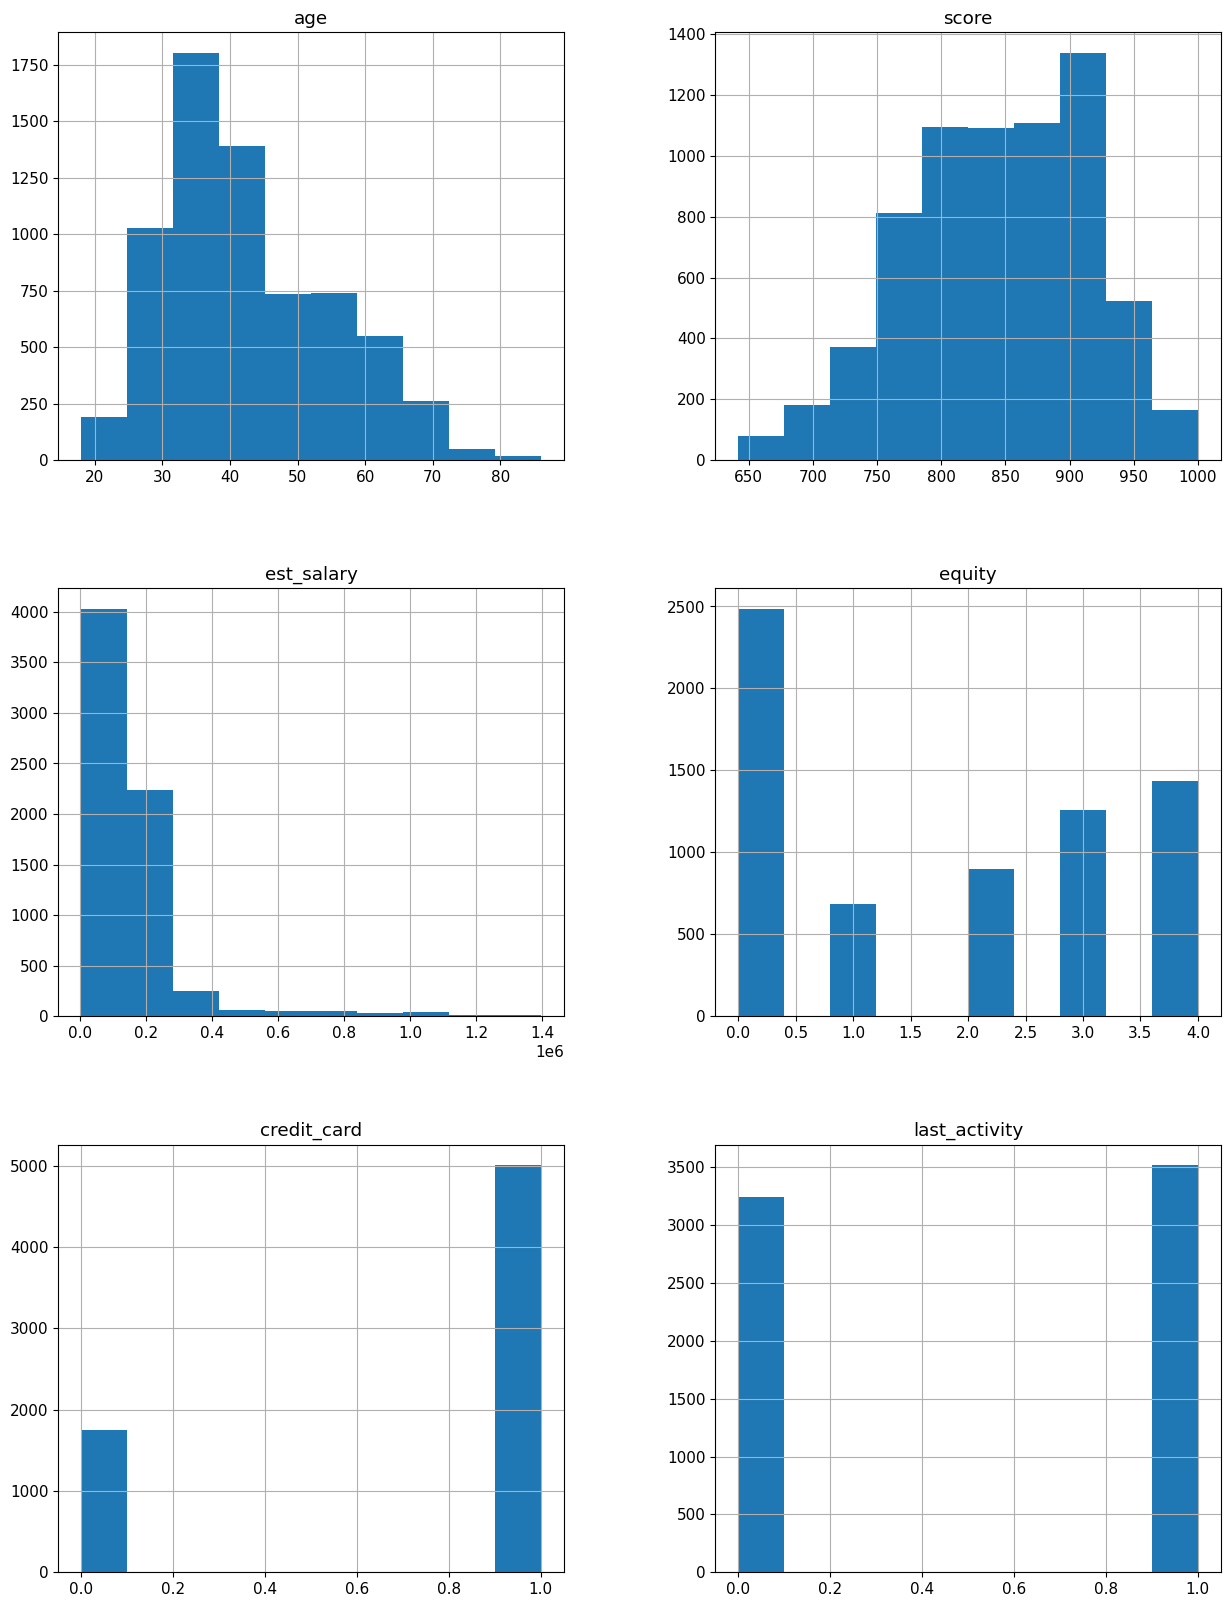

In [81]:
# визуализация статистики для "велосипедистов"
(bicyclist[['age', 'score', 'est_salary',
           'equity', 'credit_card', 'last_activity']]
 .hist(figsize=(15, 20)));

### Сегмент №2

In [82]:
# несколько строк из сегмента №2
biker.head()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
5,202305,856.0,1,56,4,863687.24,3,1,0,156619.80,0,0,1,0
6,177259,807.0,0,39,3,405042.44,3,0,1,103838.32,0,0,0,1
15,120260,731.0,1,42,3,1480548.47,3,1,0,160974.43,0,0,1,0
26,174396,898.0,0,62,3,364049.27,3,0,1,50661.84,0,0,0,1
33,125478,786.0,0,27,3,448062.52,3,1,1,37607.67,0,1,0,0


In [83]:
# общая статистика по сегменту №2
biker.describe()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
count,979.000000,979.000000,979.000000,979.000000,979.000000,9.790000e+02,979.000000,979.000000,979.000000,9.790000e+02,979.000000,979.000000,979.000000,979.000000
mean,170870.124617,840.134831,0.438202,43.747702,2.879469,8.903672e+05,3.286006,0.463739,0.516854,1.285212e+05,0.347293,0.111338,0.170582,0.718080
std,33195.882308,56.584051,0.496420,12.702458,1.235872,1.288687e+06,0.478493,0.498938,0.499971,1.062156e+05,0.476353,0.314711,0.376336,0.450165
min,96267.000000,689.000000,0.000000,19.000000,0.000000,0.000000e+00,3.000000,0.000000,0.000000,3.487330e+03,0.000000,0.000000,0.000000,0.000000
25%,142585.500000,796.000000,0.000000,34.000000,2.000000,2.979918e+05,3.000000,0.000000,0.000000,6.851083e+04,0.000000,0.000000,0.000000,0.000000
50%,172343.000000,834.000000,0.000000,40.000000,3.000000,5.454950e+05,3.000000,0.000000,1.000000,1.120350e+05,0.000000,0.000000,0.000000,1.000000
75%,197529.500000,880.000000,1.000000,53.000000,4.000000,1.201318e+06,4.000000,1.000000,1.000000,1.604770e+05,1.000000,0.000000,0.000000,1.000000
max,229058.000000,1000.000000,1.000000,83.000000,4.000000,2.572776e+07,5.000000,1.000000,1.000000,1.064019e+06,1.000000,1.000000,1.000000,1.000000


<div style="border:solid orange 1px; padding: 20px">
Общий признак этого сегмента - не более 4 баллов собственности и более 2 банковских продукта.<br>
Женщин немного больше, чем мужчин, активных и неактивных клиентов примерно поровну.<br>
Кредитной картой владеют 46%. Средний баланс - 890 тысяч. <br>
Средний возраст 43-44 года.<br>
Ушедших в отток - 35%.

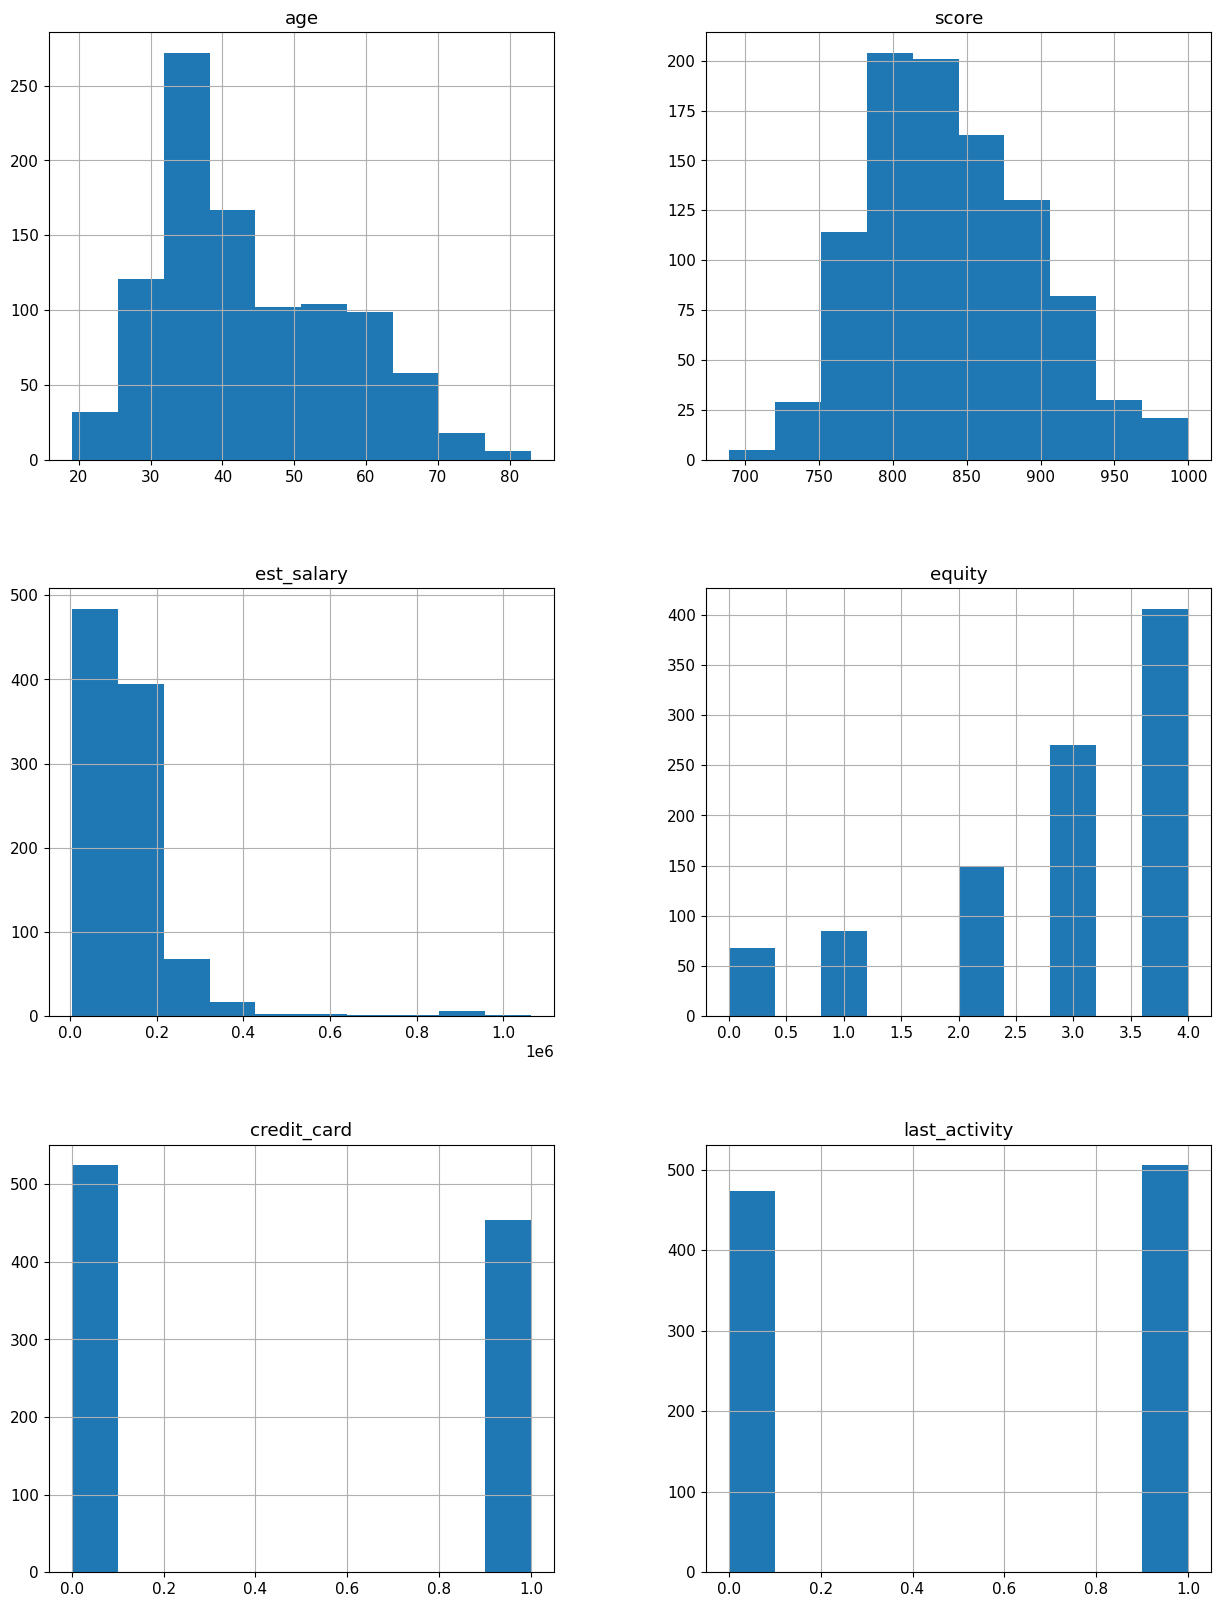

In [84]:
# визуализация статистики для "байкеров"
(biker[['age', 'score', 'est_salary',
           'equity', 'credit_card', 'last_activity']]
 .hist(figsize=(15, 20)));

### Сегмент №3

In [85]:
# несколько строк из сегмента №3
motorist.head()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
3,225363,866.0,0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,157978,730.0,1,34,5,174.00,1,1,0,67353.16,1,0,0,1
8,211686,923.0,1,54,5,1206337.87,2,1,0,155371.79,0,0,0,1
14,172138,815.0,1,35,5,547499.87,2,1,1,105883.26,0,0,0,1
16,123335,829.0,1,45,5,507842.84,1,1,1,169330.64,0,0,0,1


In [86]:
# общая статистика по сегменту №3
motorist.describe()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1.637000e+03,1637.000000,1637.000000,1637.000000,1.637000e+03,1637.000000,1637.000000,1637.000000,1637.000000
mean,171597.232743,864.937080,0.489310,42.591936,5.175932,1.161741e+06,1.799633,0.630422,0.519853,1.380768e+05,0.255956,0.161271,0.285889,0.552841
std,34007.746655,49.143474,0.500038,11.852429,0.568817,3.282178e+06,0.400397,0.482838,0.499758,1.290546e+05,0.436531,0.367893,0.451975,0.497352
min,96404.000000,724.000000,0.000000,19.000000,5.000000,1.740000e+02,1.000000,0.000000,0.000000,7.571800e+03,0.000000,0.000000,0.000000,0.000000
25%,141897.000000,829.000000,0.000000,33.000000,5.000000,5.469886e+05,2.000000,0.000000,0.000000,7.199944e+04,0.000000,0.000000,0.000000,0.000000
50%,171794.000000,868.000000,0.000000,40.000000,5.000000,7.948229e+05,2.000000,1.000000,1.000000,1.146361e+05,0.000000,0.000000,0.000000,1.000000
75%,200465.000000,901.000000,1.000000,51.000000,5.000000,1.189905e+06,2.000000,1.000000,1.000000,1.659703e+05,1.000000,0.000000,1.000000,1.000000
max,228908.000000,1000.000000,1.000000,78.000000,9.000000,1.191136e+08,2.000000,1.000000,1.000000,1.281548e+06,1.000000,1.000000,1.000000,1.000000


<div style="border:solid orange 1px; padding: 20px">
Общий признак этого сегмента - от 5 баллов собственности и 1-2 банковских продукта.<br>
Женщин и мужчин, а также активных и неактивных клиентов примерно поровну.<br>
Кредитной картой владеют 63%. Средний баланс - 1.1 миллиона. <br>
Средний возраст 42.5 года.<br>
Ушедших в отток - 26%.

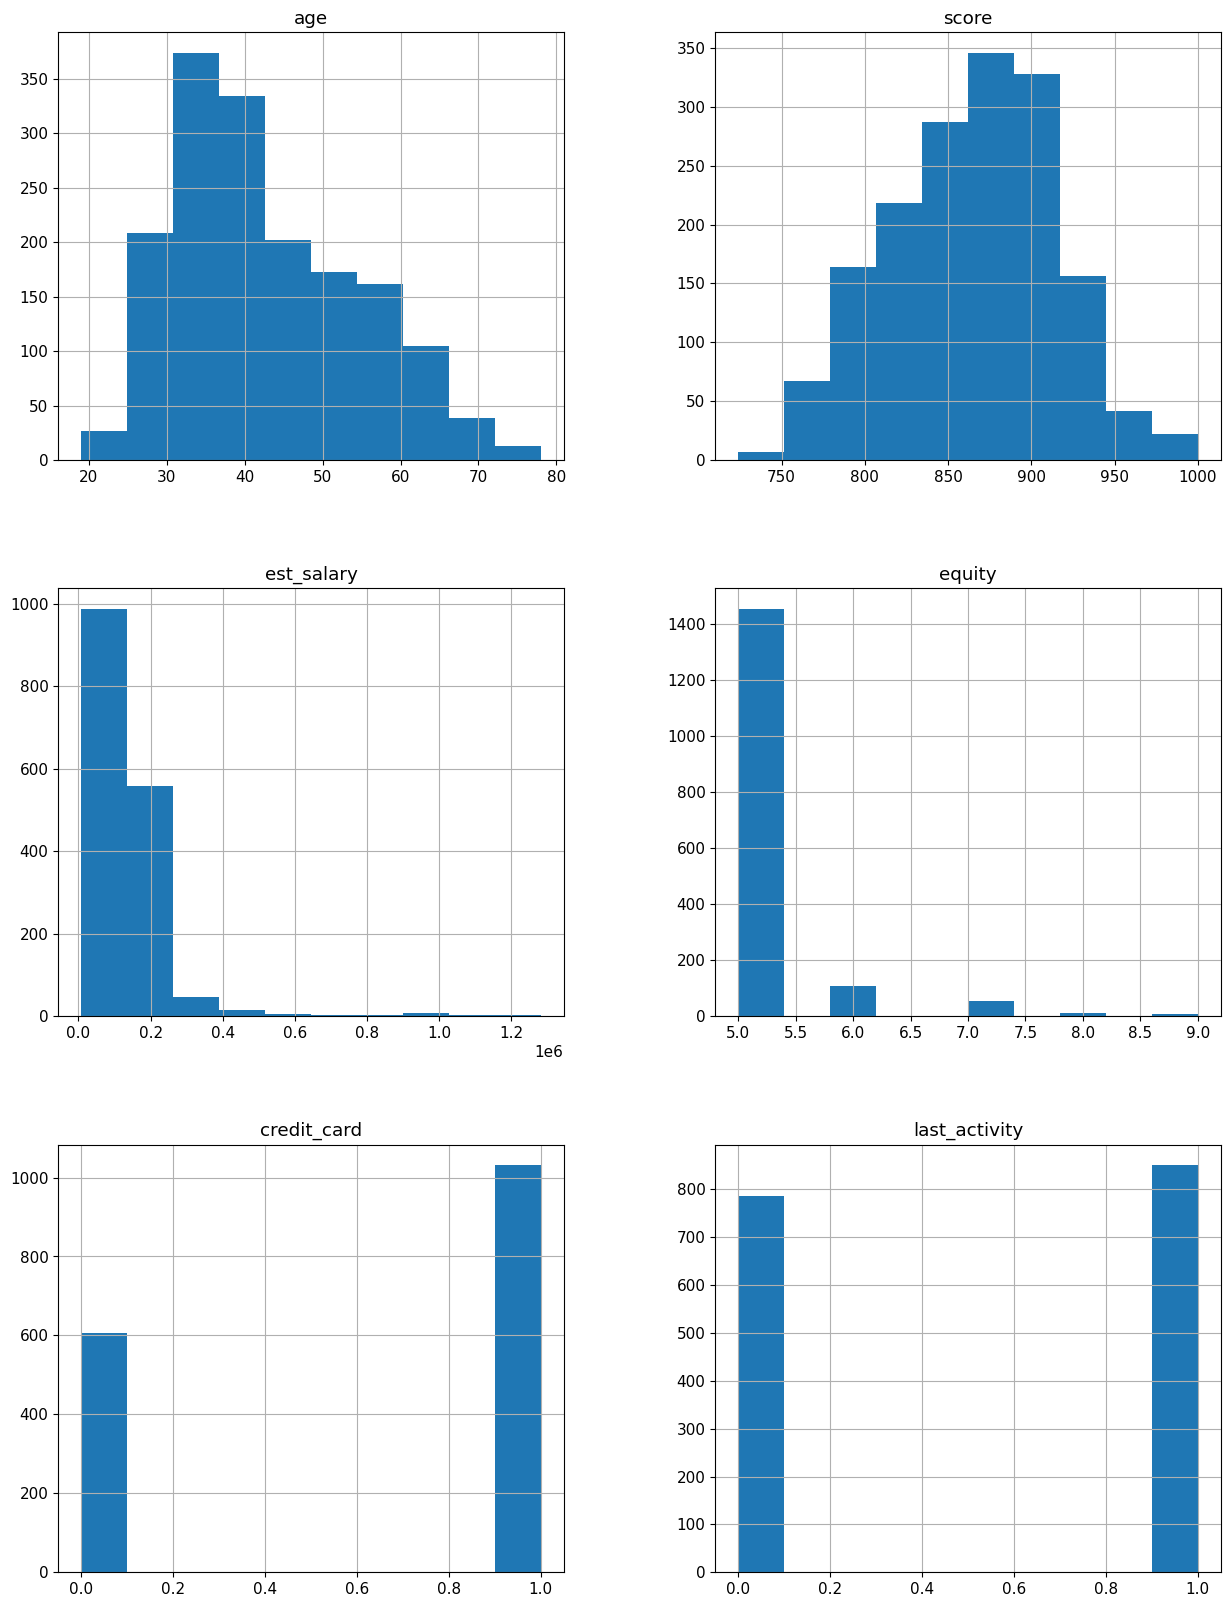

In [87]:
# визуализация статистики для "автомобилистов"
(motorist[['age', 'score', 'est_salary',
           'equity', 'credit_card', 'last_activity']]
 .hist(figsize=(15, 20)));

### Сегмент №4

In [88]:
# несколько строк из сегмента №4
racer.head()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
1,146556,861.0,0,37,5,850594.33,3,1,0,86621.77,0,0,1,0
72,156677,873.0,1,39,5,915959.85,3,0,1,154034.62,1,0,0,1
76,213688,922.0,0,37,5,1214707.38,4,0,1,85121.07,0,0,0,1
81,223978,850.0,1,34,5,351583.16,4,0,1,115354.97,1,0,1,0
148,122769,868.0,0,58,5,1334745.59,4,0,1,63049.60,1,1,0,0


In [89]:
# общая статистика по сегменту №4
racer.describe()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
count,542.000000,542.000000,542.000000,542.000000,542.000000,5.420000e+02,542.000000,542.000000,542.000000,5.420000e+02,542.000000,542.000000,542.000000,542.000000
mean,174356.896679,868.666052,0.586716,43.806273,5.247232,1.361747e+06,3.428044,0.461255,0.581181,1.465636e+05,0.488930,0.107011,0.164207,0.728782
std,36188.382150,51.915411,0.492878,12.311323,0.644715,2.115969e+06,0.520723,0.498957,0.493821,1.451678e+05,0.500339,0.309413,0.370805,0.444999
min,95384.000000,751.000000,0.000000,22.000000,5.000000,5.692547e+04,3.000000,0.000000,0.000000,8.226260e+03,0.000000,0.000000,0.000000,0.000000
25%,145070.250000,832.250000,0.000000,35.000000,5.000000,5.696601e+05,3.000000,0.000000,0.000000,6.996043e+04,0.000000,0.000000,0.000000,0.000000
50%,177111.000000,868.000000,1.000000,41.000000,5.000000,9.867240e+05,3.000000,0.000000,1.000000,1.140276e+05,0.000000,0.000000,0.000000,1.000000
75%,207114.500000,909.000000,1.000000,53.000000,5.000000,1.539197e+06,4.000000,1.000000,1.000000,1.794371e+05,1.000000,0.000000,0.000000,1.000000
max,229017.000000,987.000000,1.000000,76.000000,9.000000,4.327710e+07,5.000000,1.000000,1.000000,1.363550e+06,1.000000,1.000000,1.000000,1.000000


<div style="border:solid orange 1px; padding: 20px">
Общий признак этого сегмента - от 5 баллов собственности и более 2 банковских продукта.<br>
Мужчин больше, чем женщин. Активных клиентов больше, чем неактивных.<br>
Кредитной картой владеют 46%. Средний баланс - 1.3 миллиона. <br>
Средний возраст 43-44 года.<br>
Ушедших в отток - 49%.

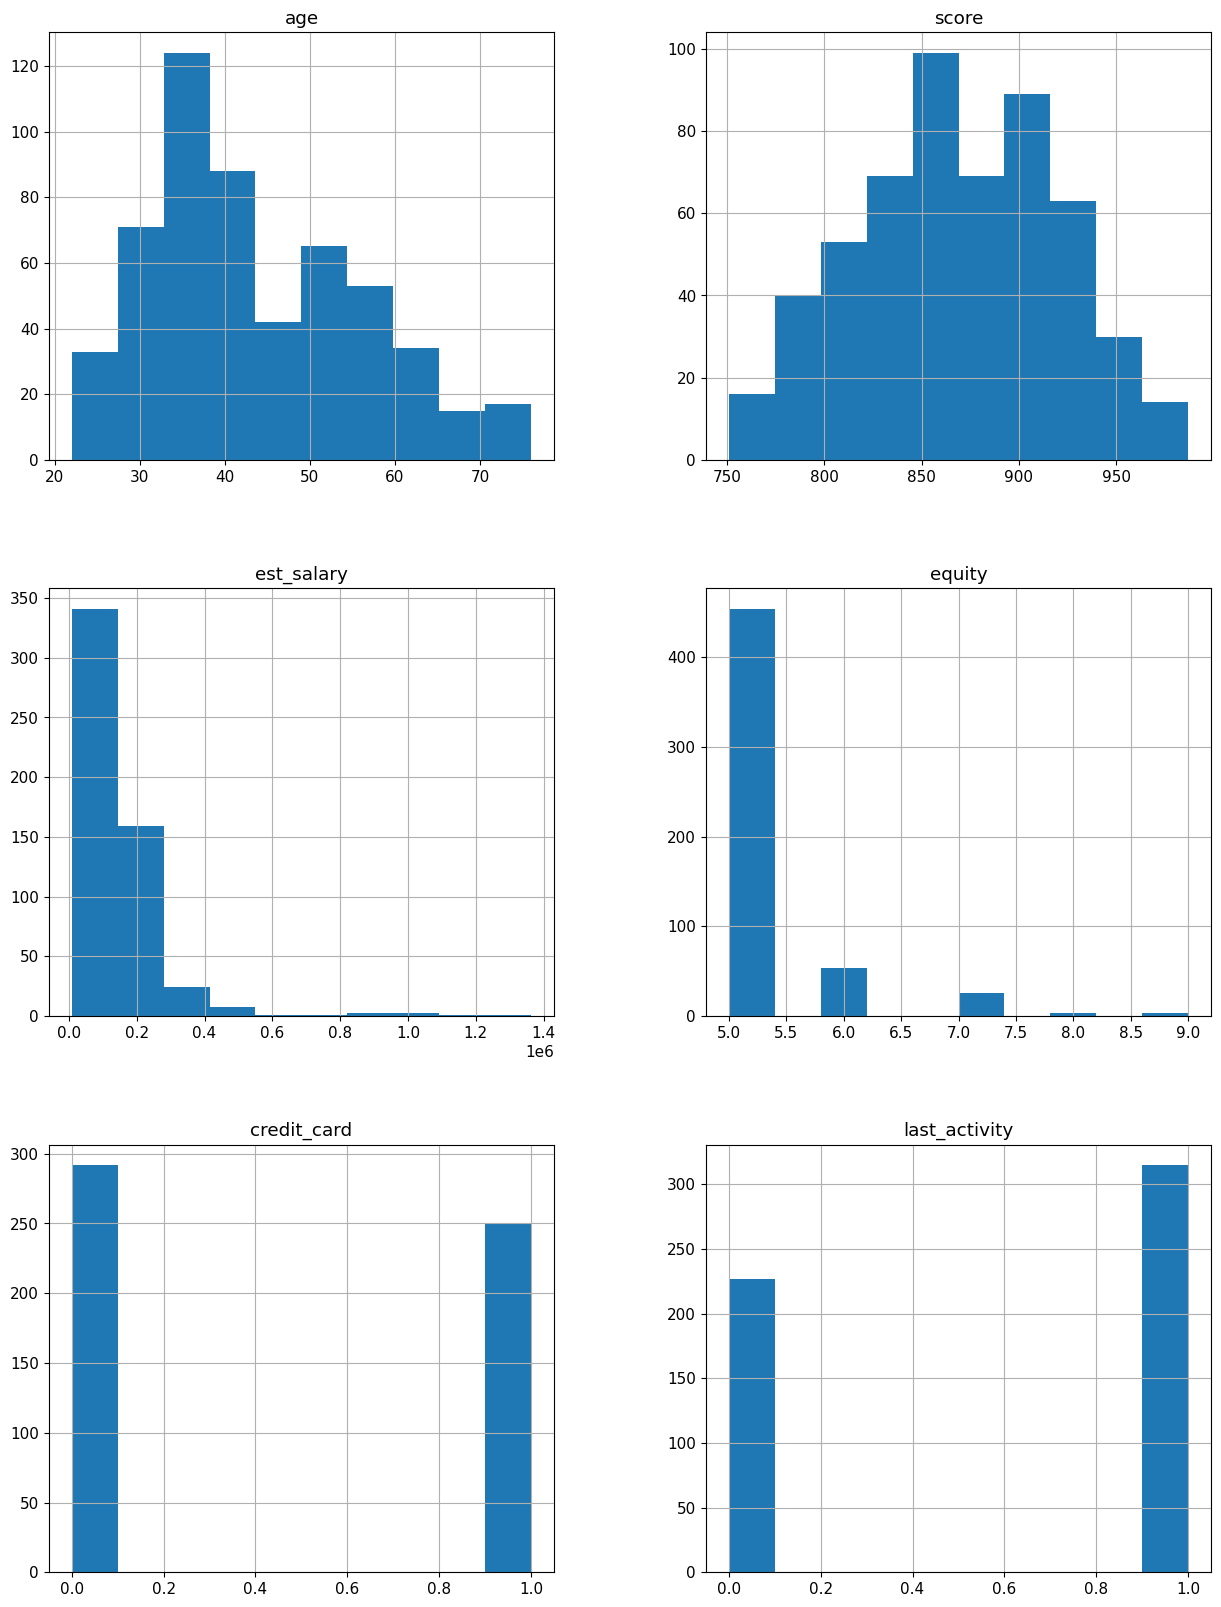

In [90]:
# визуализация статистики для "гонщиков"
(racer[['age', 'score', 'est_salary',
           'equity', 'credit_card', 'last_activity']]
 .hist(figsize=(15, 20)));

### Вывод 5

Мы разделили клиентов банка на 4 сегмента по двум признакам - балл собственности и количество продуктов.<br>
На первое и второе место по доле отточных клиентов вышли "гонщики" и "байкеры" - 49% и 35% соответственно.<br>
Общий признак для них - это использование от 3 до 5 банковских продуктов, а также доля владельцев кредитной карты - 46%.<br>
Отличаются в этих группах баланс и гендерный состав: в группе "байкеров" чуть больше женщин и средний баланс 890 тысяч,<br>
а в группе "гонщиков" больше мужчин и средний баланс 1.3 миллиона.<br><br>
    
На третьем и четвёртом месте по отточности расположились "автомобилисты" и "велосипедисты" - 25% и 12% соответственно.<br>
Общее для них: 1-2 банковских продукта, 63-74% держателей кредитной карты, мужчин и женщин поровну.<br>
А вот средний баланс существенно отличается: у "велосипедистов" - 419 тыс., у "автомобилистов" - 1.1 млн.

## Рекомендации

В первую очередь следует обратить внимание на сегмент №4 ("гонщики"), и сегмент №2 ("байкеры"),<br>
в которые вошли клиенты, использующие от 3 до 5 банковских продукта.<br>
Доля отточных в этих сегментах самая большая по сравнению с другими сегментами и составляет 49% для "гонщиков" и 35% для "байкеров".<br><br>

Можно предположить, что отток в этих группах связан с неудовлетворенностью инструментами управления продуктами. <br>
Чем больше продуктов, тем больше внимания и компетенций требуется для согласованной работы с ними.<br>
Из этого следует, что инструменты управления продуктами, предоставляемые банком клиенту,<br>
должны быть скоординированы между собой. <br><br>

В идеале лучше, чтобы это был один инструмент, позволяющий управлять различными продуктами как одной системой. <br>
При этом быстро, удобно и понятно.<br><br>

Кроме того, клиенты склонны искать более выгодные предложения<br>
и, скорее всего, рассматривают конкурентов с такими же банковскими продуктами. <br>
Если с одним-двумя продуктами довольно легко принять решение, выбрав более выгодные условия,<br>
то в случае с большим количеством продуктов необходимо искать баланс, а где-то и компромисс, что уже немного более сложная задача.<br><br>

Другими словами, клиентам нужен удобный и эффективный инструмент управления продуктами.<br>
Возможно, с личным ассистентом на базе ИИ, учитывающим контекст и историю клиента.

## Общий вывод

Исследование показало наличие проблем с клиентами, которые пользуются 4-5 банковскими продуктами и имеют сравнительно большие суммы на счёте.
Их отток может быть связан с неудовлетворённостью тем, как банк осуществляет обслуживание по нескольким продуктам одновременно.
Возможно, они ищут большей согласованности между различными продуктами, сбалансированности преимуществ, которые даёт каждый продукт, и более удобный инструмент управления своей финансовой активностью.